#**All Imported Libraries**

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, AveragePooling1D, SimpleRNN, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from keras.callbacks import History
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import shap
import warnings
warnings.filterwarnings('ignore')

#**Loading The Data**

***Mounting Google Drive to Colab to access dataset files.***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
table_1=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_1.csv")
table_2=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_2.csv")
table_3=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_3.csv")
table_4=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_4.csv")
table_5=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_5.csv")
table_6=pd.read_csv("/content/drive/MyDrive/LSM DATASET LINK/PART_6.csv")

#Merging all the files into one table

dataset = pd.concat([table_1,table_2,table_3,table_4,table_5,table_6])
dataset.reset_index(drop=True, inplace=True)

In [ ]:
print(dataset.shape)
print("")
dataset.head()

(6228310, 17)



,fid,longitude,latitude,landslide_occ,geology,geomorphology,lithology,soil_class,dist_to_water,dist_to_road,lulc,rainfall,tan_cur,prof_curv,aspect,elevation,slope
0,1,222975,3393585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00153,-0.00717,45.00000,1788,14.21836
1,2,223005,3393585,NaN,5.0,2.0,30.0,1.0,2201.45703,984.07318,2.0,NaN,-0.00350,-0.01248,46.94149,1775,19.18077
2,3,223035,3393585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.00268,-0.01215,32.00538,1768,13.27067
3,4,222885,3393555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.00593,0.00941,78.02386,1827,8.00104
4,5,222915,3393555,NaN,5.0,2.0,30.0,1.0,2205.94873,926.12097,4.0,NaN,-0.00233,-0.00700,62.35403,1814,16.50623


In [ ]:
dataset.info() #All columns are numeric - continuous and discrete values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228310 entries, 0 to 6228309
Data columns (total 17 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fid            int64  
 1   longitude      int64  
 2   latitude       int64  
 3   landslide_occ  float64
 4   geology        float64
 5   geomorphology  float64
 6   lithology      float64
 7   soil_class     float64
 8   dist_to_water  float64
 9   dist_to_road   float64
 10  lulc           float64
 11  rainfall       float64
 12  tan_cur        float64
 13  prof_curv      float64
 14  aspect         float64
 15  elevation      int64  
 16  slope          float64
dtypes: float64(13), int64(4)
memory usage: 807.8 MB


#**Handling Missing/Null Values**

In [ ]:
dataset.isnull().sum()

fid                    0
longitude              0
latitude               0
landslide_occ    6227428
geology             1487
geomorphology       1947
lithology           1946
soil_class          1948
dist_to_water       2253
dist_to_road        1487
lulc                1948
rainfall            3211
tan_cur                0
prof_curv              0
aspect                 0
elevation              0
slope                  0
dtype: int64

In [ ]:
#filling null values in geology, geomorphology, lithology, soil class, and LULC with their respective modes.
dataset['geology'].fillna(dataset['geology'].mode().iloc[0], inplace=True)
dataset['geomorphology'].fillna(dataset['geomorphology'].mode().iloc[0], inplace=True)
dataset['lithology'].fillna(dataset['lithology'].mode().iloc[0], inplace=True)
dataset['soil_class'].fillna(dataset['soil_class'].mode().iloc[0], inplace=True)
dataset['lulc'].fillna(dataset['lulc'].mode().iloc[0], inplace=True)

In [ ]:
#filling null values in distance to water bodies, distance to roads, and rainfall with their respective mean values.
dataset['dist_to_water'].fillna(dataset['dist_to_water'].mean(), inplace=True)
dataset['dist_to_road'].fillna(dataset['dist_to_road'].mean(), inplace=True)
dataset['rainfall'].fillna(dataset['rainfall'].mean(), inplace=True)

In [ ]:
#Imputing 0 for null values in the column - landslide_occ, which signifies 0 for no occurence of landslide.
dataset['landslide_occ'].fillna(0, inplace=True)

In [ ]:
dataset['landslide_occ'].value_counts()

landslide_occ
0.0    6227428
1.0        882
Name: count, dtype: int64

#**Plotting Graphs**

### ***Histograms***

In [ ]:
dataset['landslide_occ'].value_counts()

0.0    6227428
1.0        882
Name: landslide_occ, dtype: int64

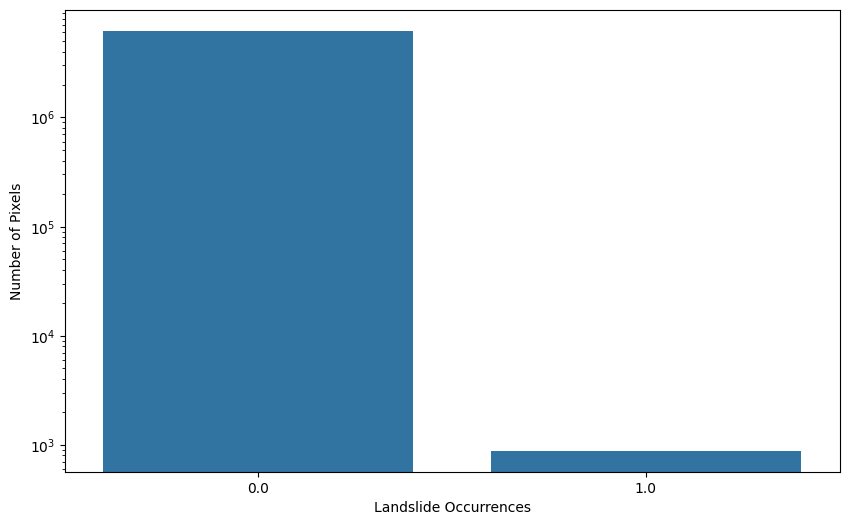

In [ ]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='landslide_occ', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Landslide Occurrences')
plt.yscale('log')
plt.show()

In [ ]:
#Histogram plots of each feature with landslide & non-landslide data

def plot_histograms(dataset, features):
  rows = len(features)

  landslide_data = dataset[dataset['landslide_occ'] == 1]
  non_landslide_data = dataset[dataset['landslide_occ'] == 0]

  plt.figure(figsize=(35, 150))

  for i, feature in enumerate(features, start=1):

    plt.subplot(rows*2, 2, i*2-1)
    plt.hist(non_landslide_data[feature], bins=30, color='blue', alpha=0.5, label='Non-Landslide')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.legend()

    plt.subplot(rows*2, 2, i*2)
    plt.hist(landslide_data[feature], bins=30, color='red', alpha=0.5, label='Landslide')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.legend()

  plt.show()

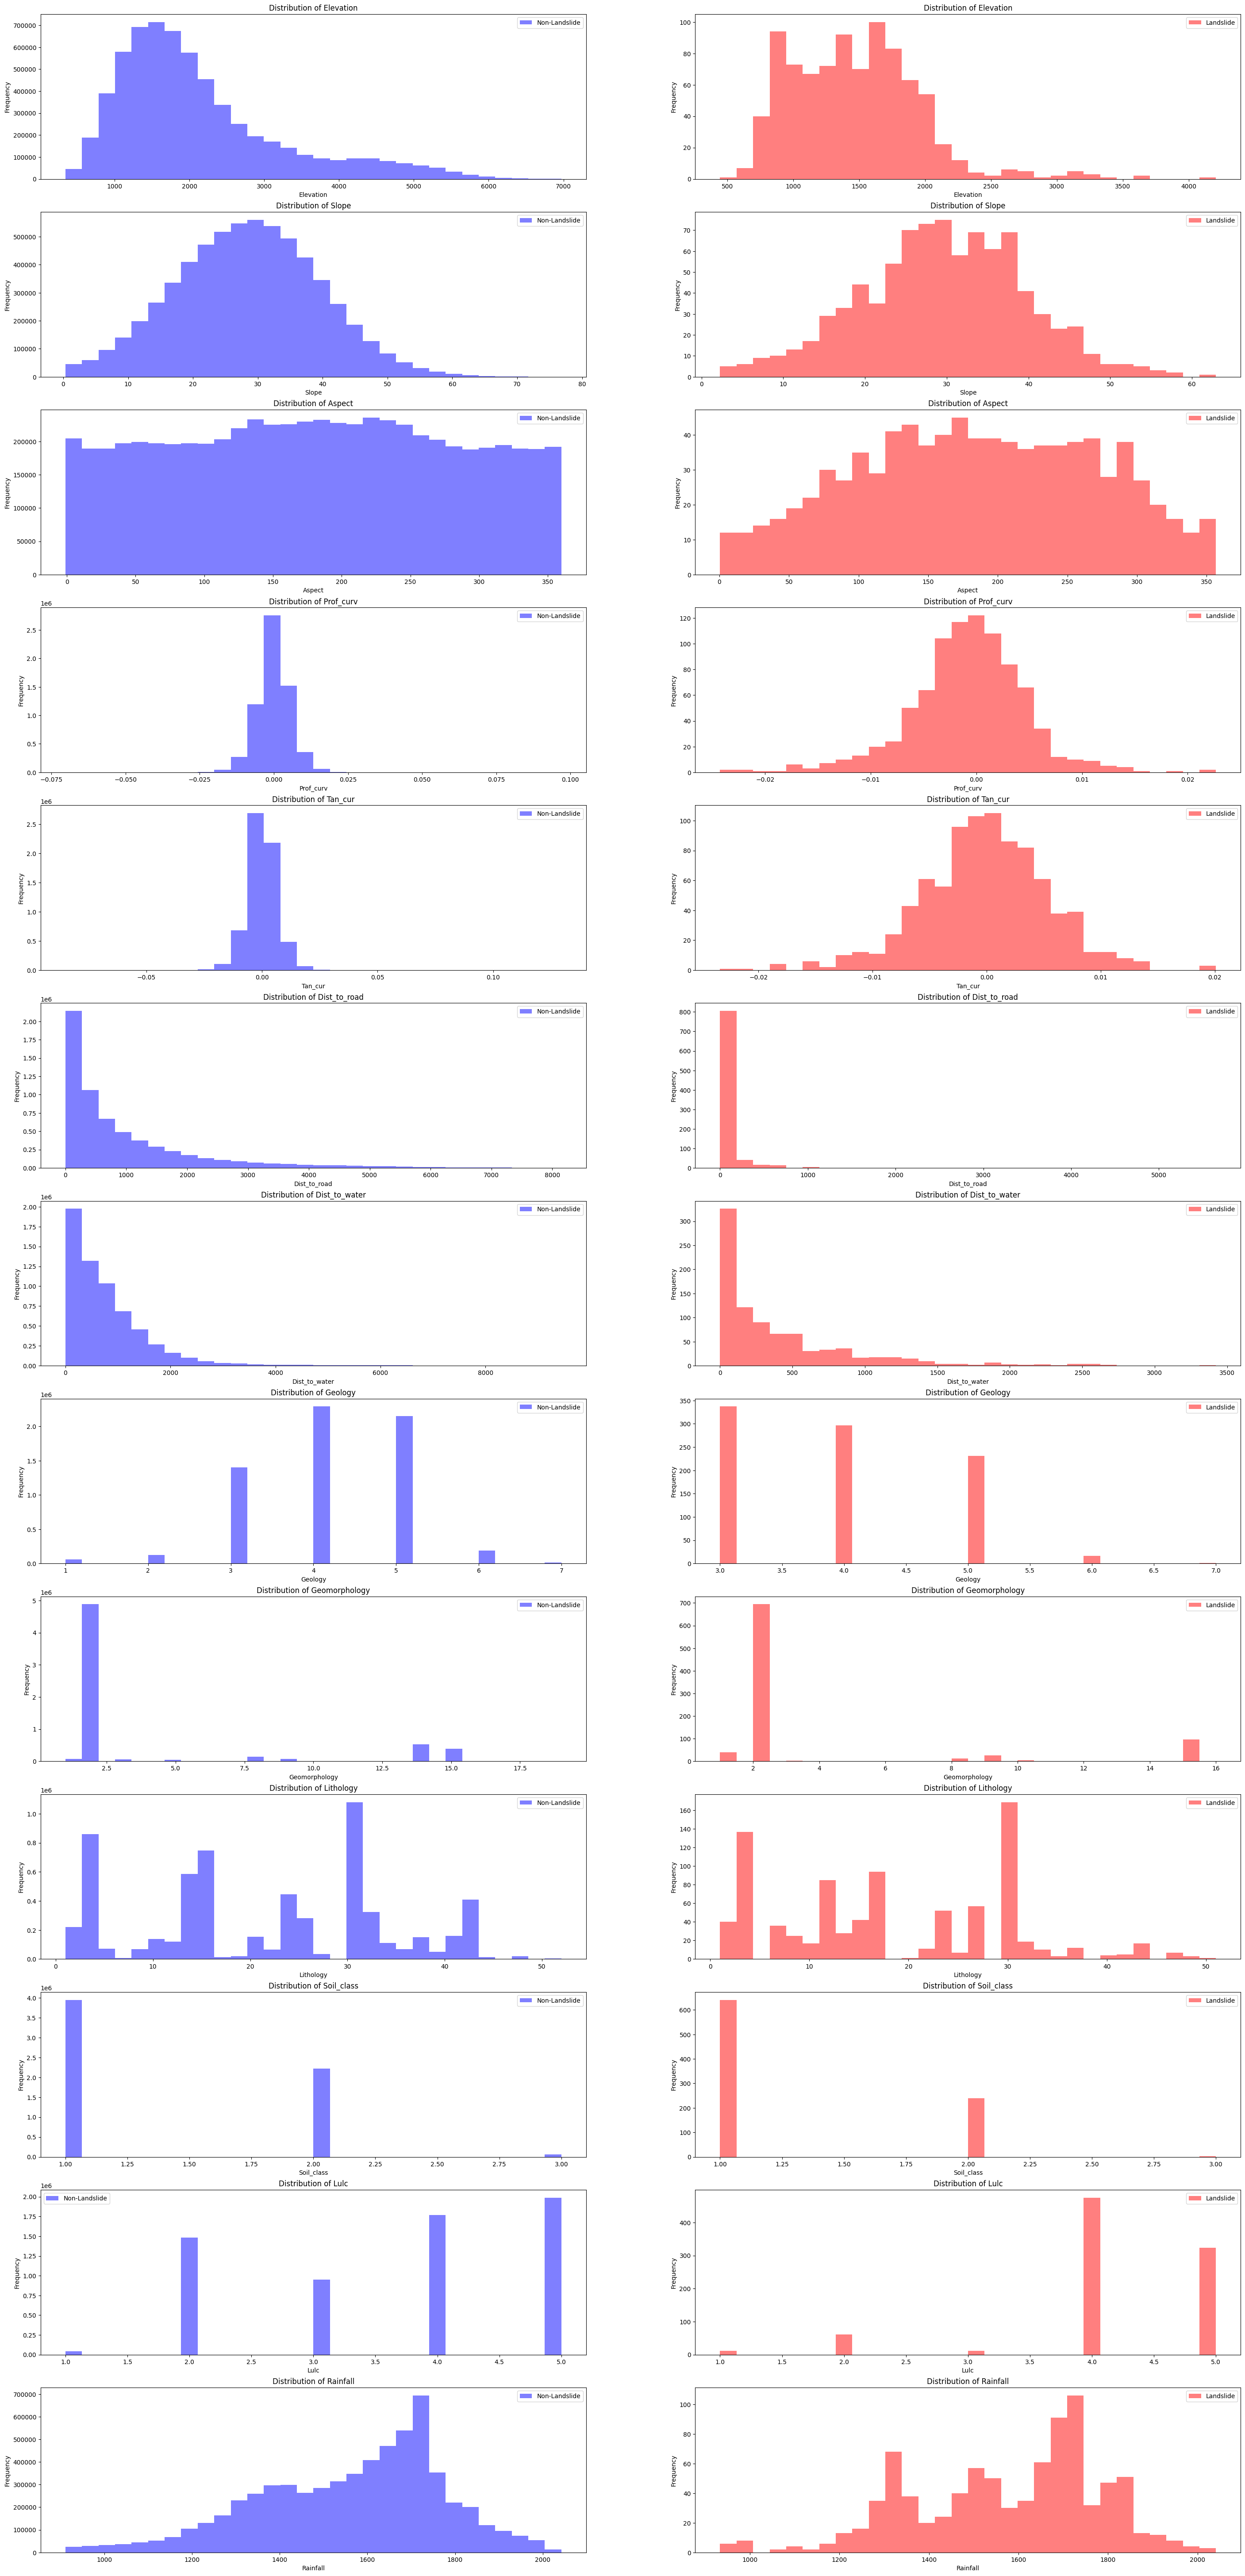

In [ ]:
features = ['elevation', 'slope', 'aspect', 'prof_curv', 'tan_cur',
                    'dist_to_road', 'dist_to_water', 'geology', 'geomorphology',
                    'lithology', 'soil_class', 'lulc', 'rainfall']

plot_histograms(dataset, features)

### ***Countplots***

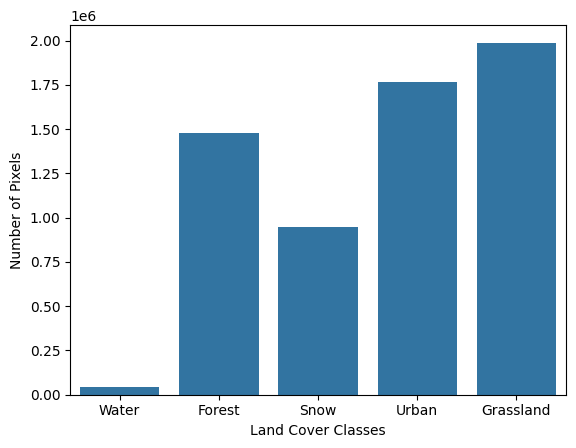

In [ ]:
ax=sns.countplot(x='lulc', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Land Cover Classes')
custom_labels = ['Water','Forest','Snow','Urban', 'Grassland']
ax.set_xticklabels(custom_labels)
plt.show()

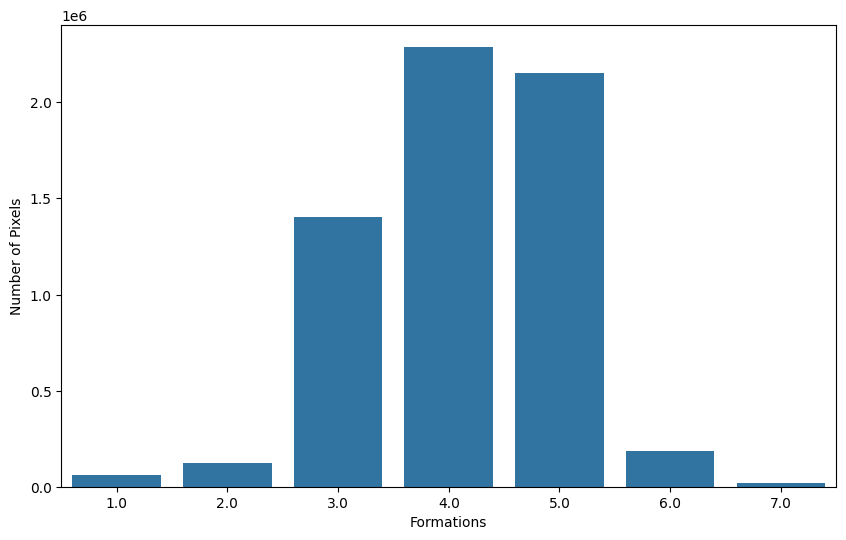

In [ ]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='geology', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Formations')
plt.show()

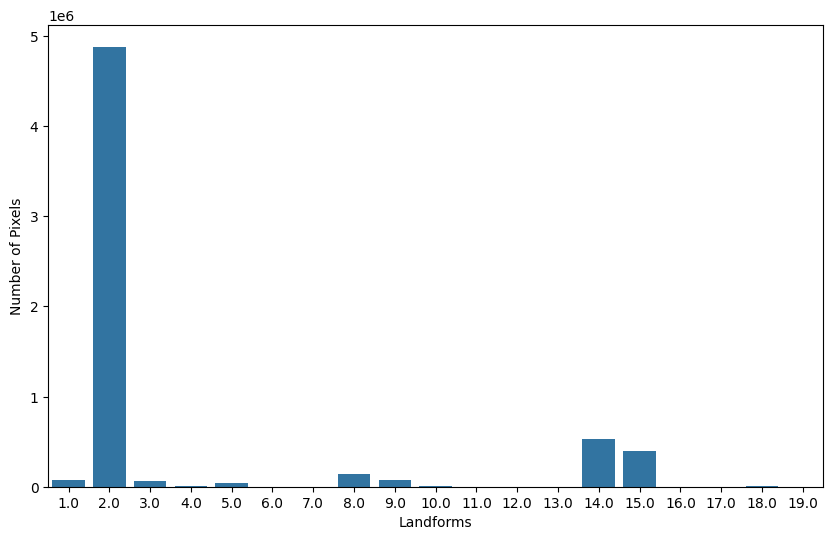

In [ ]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='geomorphology', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Landforms')
plt.show()

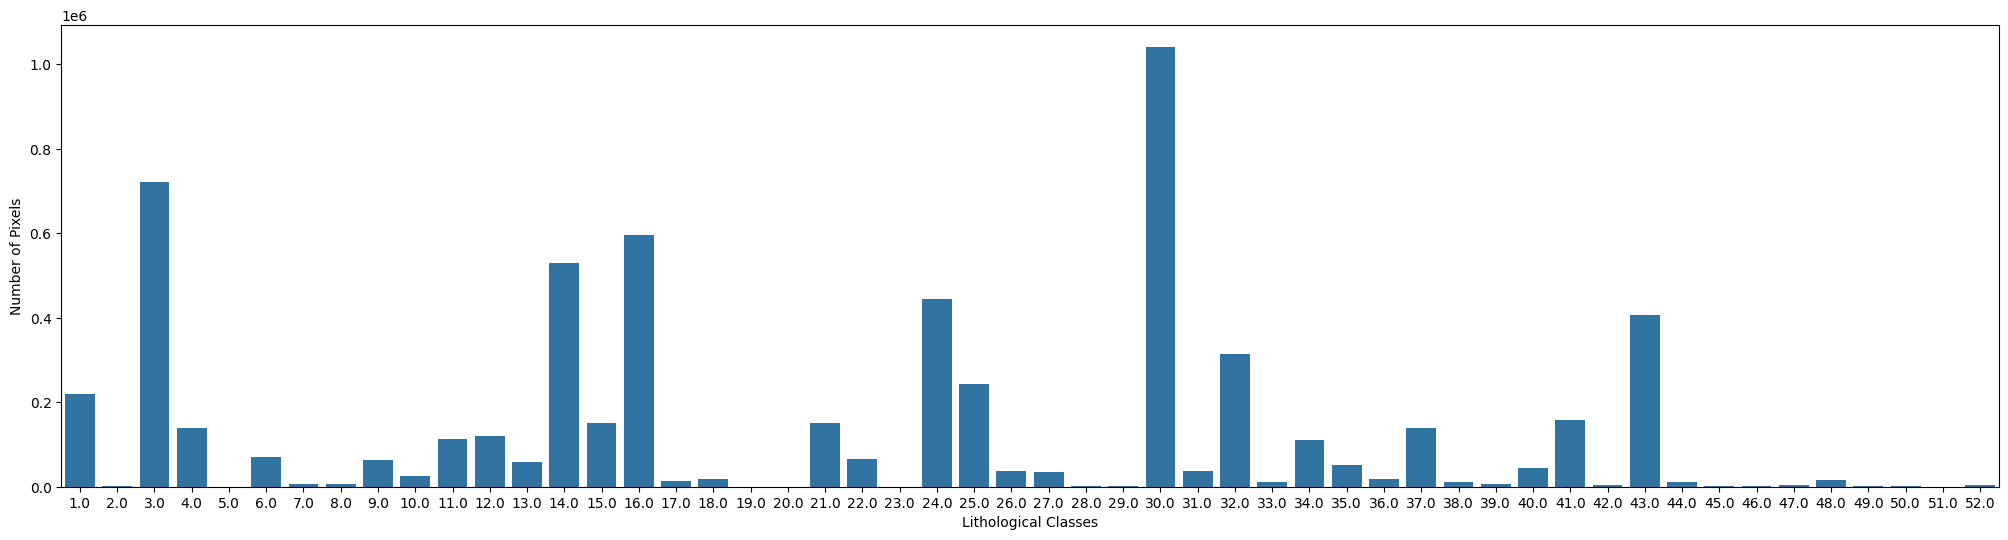

In [ ]:
plt.figure(figsize=(25, 6))
ax=sns.countplot(x='lithology', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Lithological Classes')
plt.show()

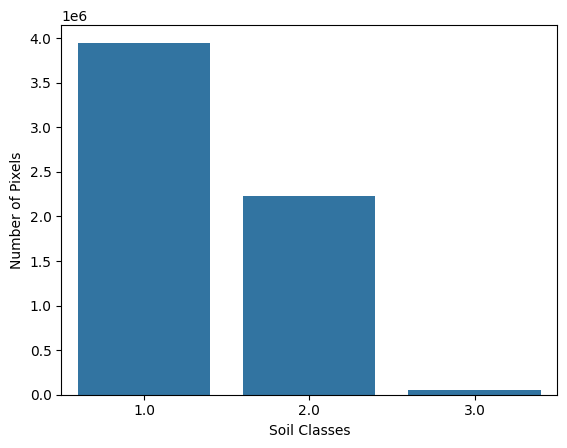

In [ ]:
ax=sns.countplot(x='soil_class', data=dataset)
plt.ylabel('Number of Pixels')
plt.xlabel('Soil Classes')
plt.show()

### ***Box Plots***

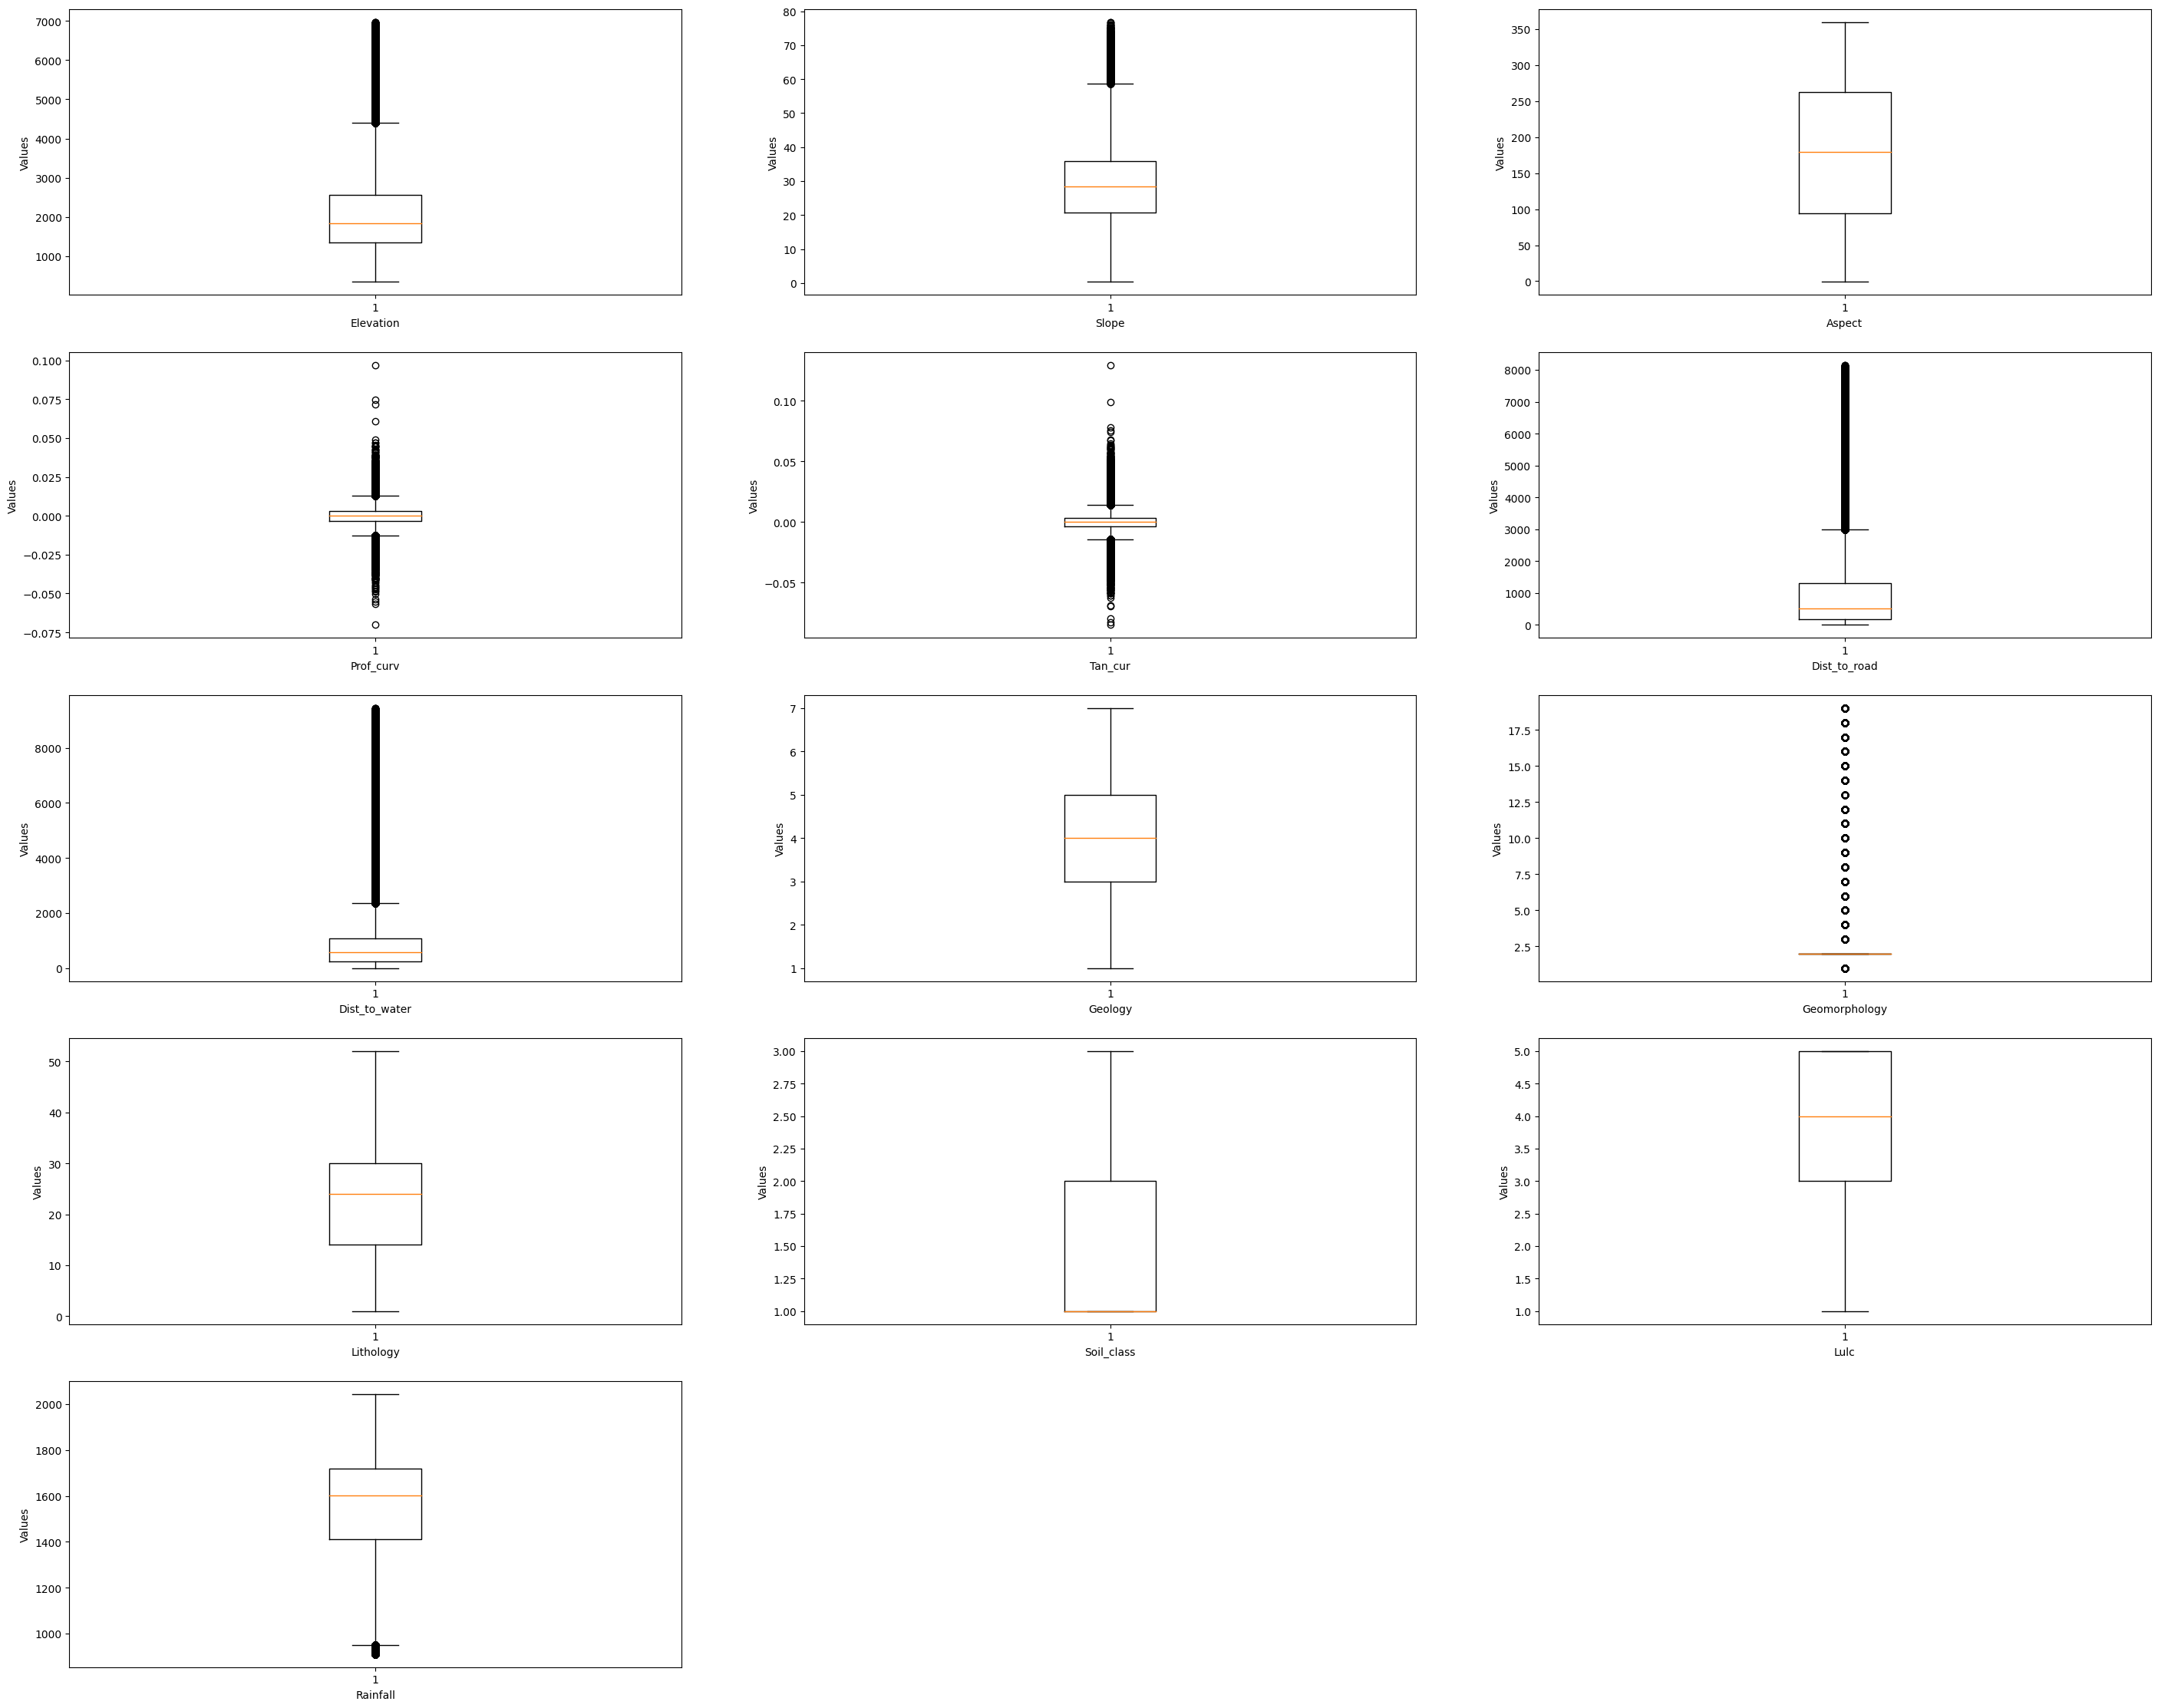

In [ ]:
plt.figure(figsize=(35, 150))
for i, feature in enumerate(features, start=1):
  plt.subplot(len(features)*2, 3, i)
  plt.boxplot(dataset[feature].tolist())
  plt.xlabel(feature.capitalize())
  plt.ylabel('Values')
plt.show()

### ***Violin Plots***

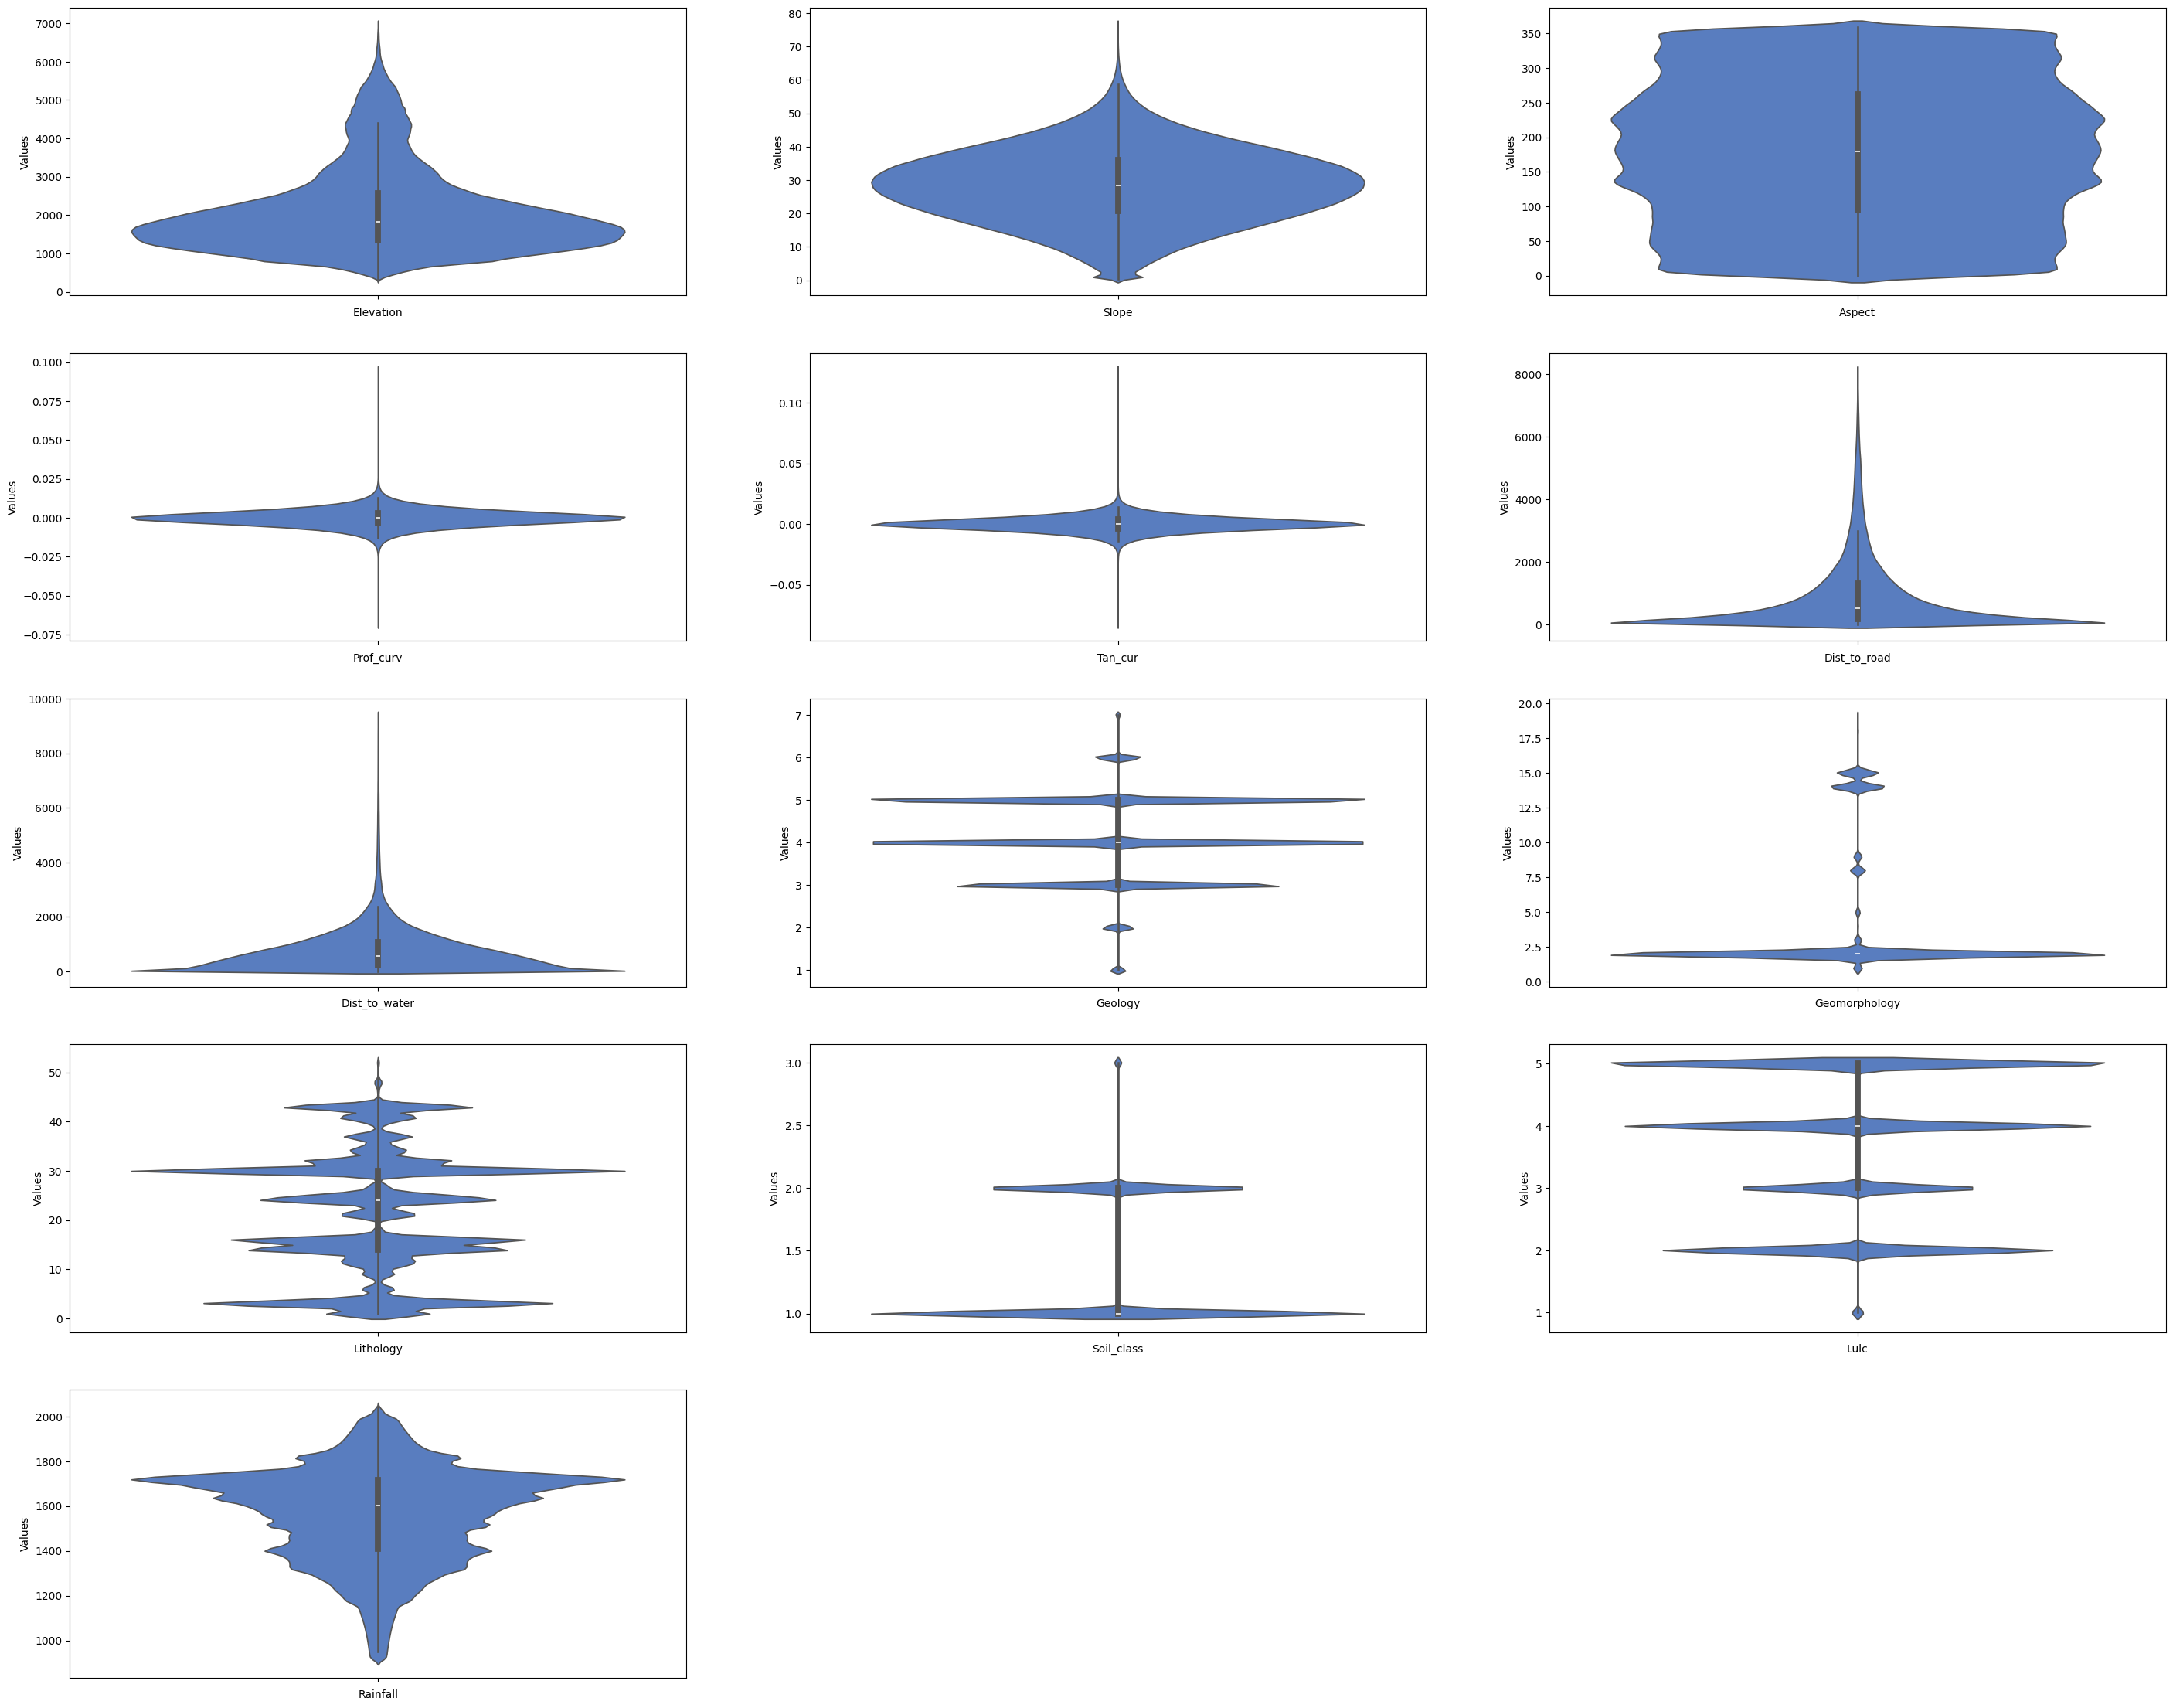

In [ ]:
plt.figure(figsize=(35, 150))
for i, feature in enumerate(features, start=1):
  plt.subplot(len(features)*2, 3, i)
  sns.violinplot(y=dataset[feature], palette='muted')
  plt.xlabel(feature.capitalize())
  plt.ylabel('Values')
plt.show()

### ***Heatmap: Correlation Matrix***

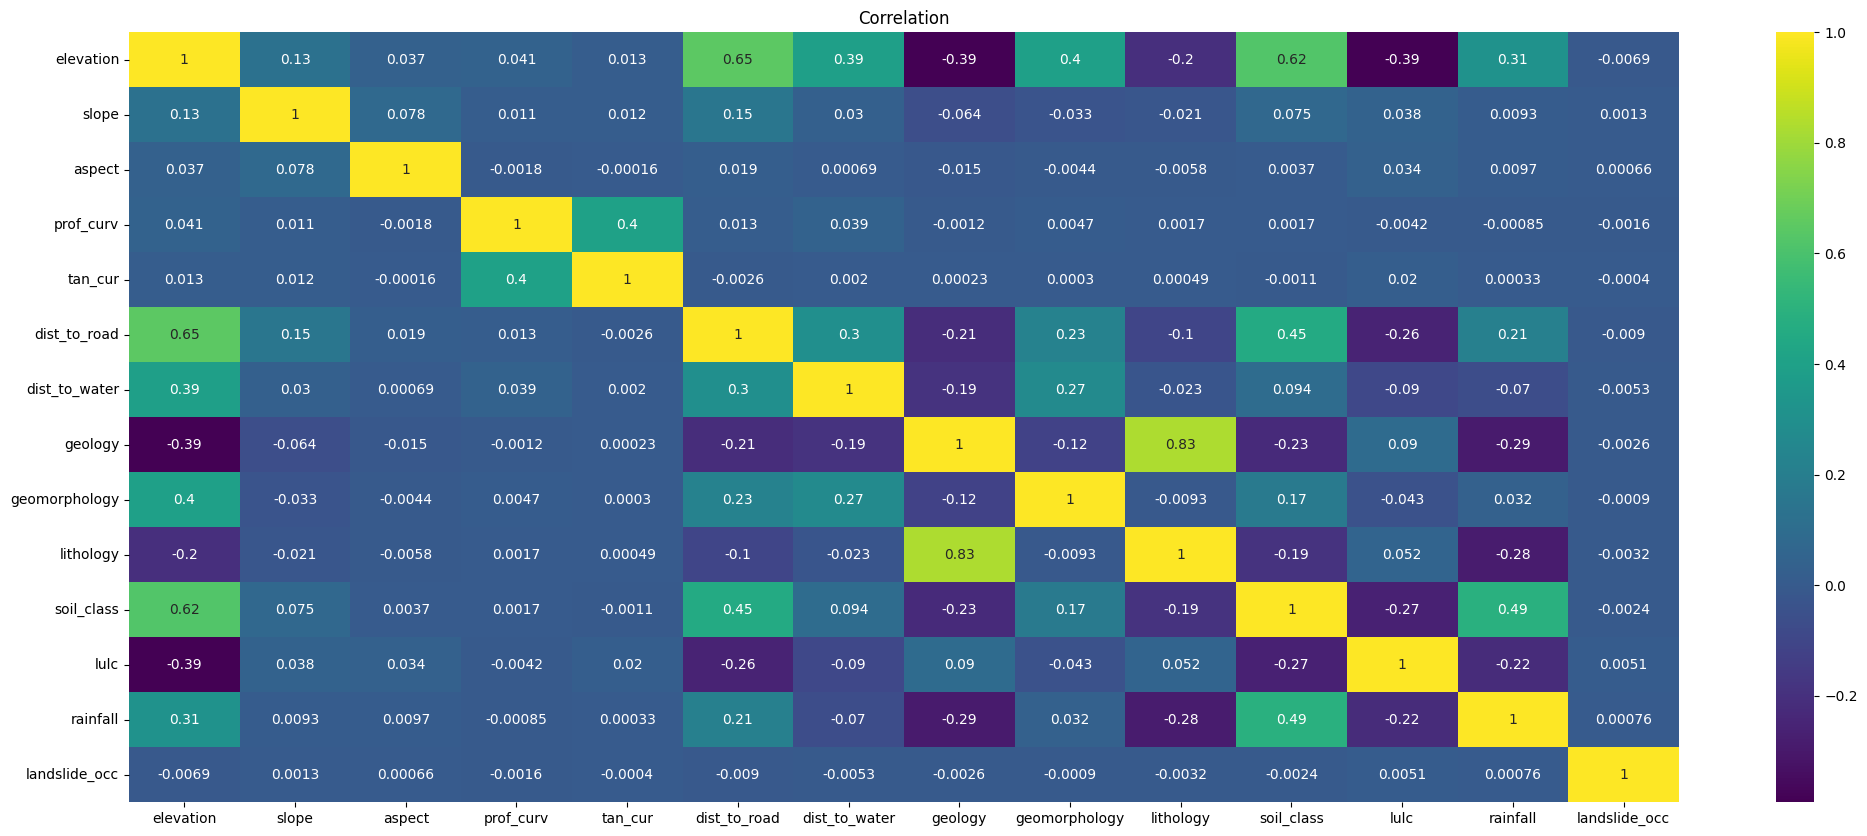

In [ ]:
plt.figure(figsize=(25, 10))
plt.title("Correlation")
sns.heatmap(dataset[['elevation', 'slope', 'aspect', 'prof_curv', 'tan_cur',
                    'dist_to_road', 'dist_to_water', 'geology', 'geomorphology',
                    'lithology', 'soil_class', 'lulc', 'rainfall', 'landslide_occ']].corr(), annot=True, cmap='viridis')
plt.show()

### ***Skewness***

In [ ]:
dataset[['elevation', 'slope', 'aspect', 'prof_curv', 'tan_cur',
                    'dist_to_road', 'dist_to_water', 'geology', 'geomorphology',
                    'lithology', 'soil_class', 'lulc', 'rainfall']].skew()

elevation        1.258857
slope            0.057016
aspect          -0.008499
prof_curv       -0.007866
tan_cur          0.007932
dist_to_road     2.124111
dist_to_water    3.177510
geology         -0.367974
geomorphology    1.768280
lithology        0.012030
soil_class       0.728279
lulc            -0.326706
rainfall        -0.510755
dtype: float64

# **Modelling**

### ***Dataset Without Being Handled for Outliers or Skewness.***

In [ ]:
X = dataset.drop(['landslide_occ','fid','longitude','latitude'], axis=1) #Remove unwanted columns and keep only the predictor features

In [ ]:
y = dataset['landslide_occ']

In [ ]:
X =  dataset[['elevation', 'slope', 'aspect', 'prof_curv', 'tan_cur',
                    'dist_to_road', 'dist_to_water', 'geomorphology',
                    'lithology', 'soil_class', 'lulc']]

vif_data = pd.DataFrame()
vif_data["feature"] =X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data)

          feature        VIF
0       elevation  13.473392
1           slope   7.283217
2          aspect   3.976189
3       prof_curv   1.197643
4         tan_cur   1.194639
5    dist_to_road   2.858667
6   dist_to_water   2.302596
7   geomorphology   2.294531
8       lithology   3.528115
9      soil_class  12.496654
10           lulc   7.849419


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4982648, 13)
(1245662, 13)
(4982648,)
(1245662,)


In [ ]:
print(y.value_counts())
print()
print(y_train.value_counts())
print()
print(y_test.value_counts())

landslide_occ
0.0    6227428
1.0        882
Name: count, dtype: int64

landslide_occ
0.0    4981942
1.0        706
Name: count, dtype: int64

landslide_occ
0.0    1245486
1.0        176
Name: count, dtype: int64


### **Random Forest**

In [ ]:
class_weights = dict(zip([0, 1], [len(y_train) / (2 * sum(y_train == 0)), len(y_train) / (2 * sum(y_train == 1))]))
print(class_weights) #deriving class weights to be passed for model training

{0: 0.5000708559031799, 1: 3528.787535410765}


In [ ]:
#Random Forest model architecture
rf_classifier = RandomForestClassifier(class_weight=class_weights,random_state=42,n_estimators=17,min_samples_split=5, max_features=7,max_depth=6)

In [ ]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5000708559031799,
                                     1: 3528.787535410765},
                       max_depth=6, max_features=7, min_samples_split=5,
                       n_estimators=17, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
overall_accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {overall_accuracy}')

Model Accuracy: 0.9223248361112405


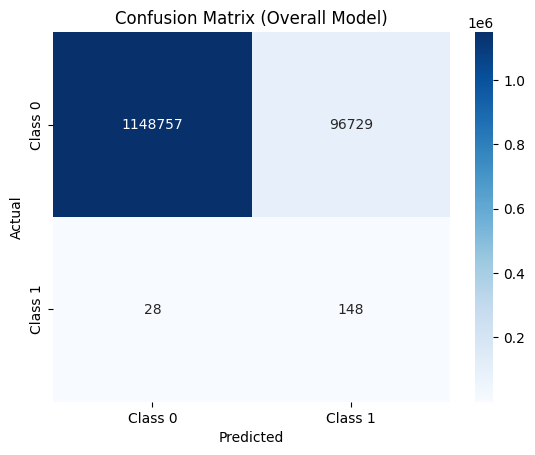

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Overall Model)')
plt.show()

In [ ]:
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.94


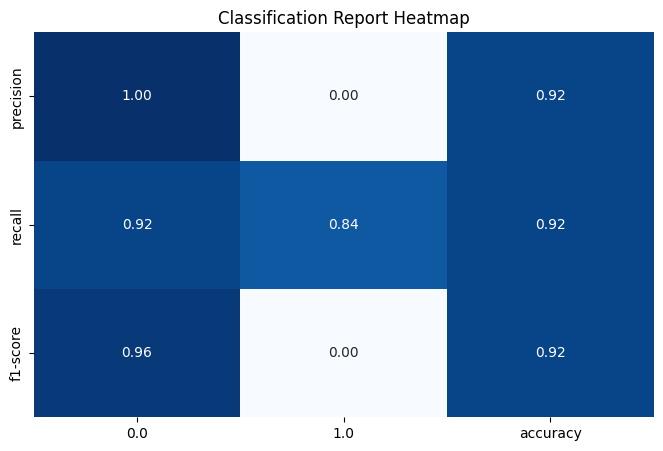

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap')
plt.show()

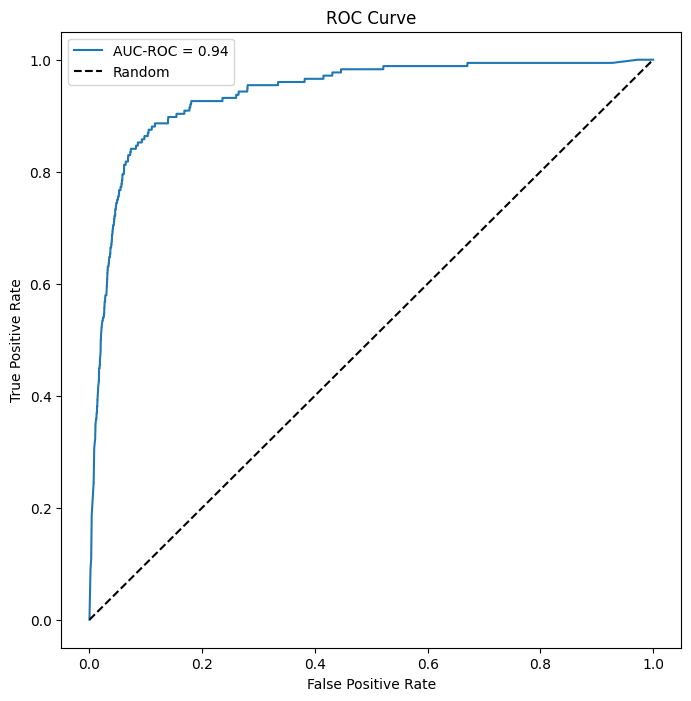

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### **Probabilities**

In [ ]:
dataset_shuffled = shuffle(dataset, random_state=0)
dataset_proba=dataset_shuffled.drop(['fid','longitude','latitude','landslide_occ'],axis=1,inplace=False)
probabilities = rf_classifier.predict_proba(dataset_proba)

In [ ]:
probabilities

array([[0.98107853, 0.01892147],
       [0.84577815, 0.15422185],
       [0.32391127, 0.67608873],
       ...,
       [0.98753868, 0.01246132],
       [0.99636743, 0.00363257],
       [0.97016346, 0.02983654]])

In [ ]:
class_1_probabilities = probabilities[:, 1]

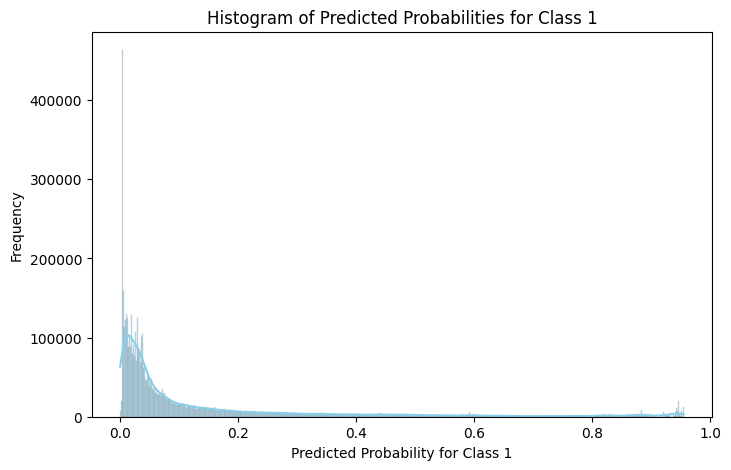

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(class_1_probabilities, kde=True, color='skyblue')
plt.title('Histogram of Predicted Probabilities for Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.show()

In [ ]:
len(class_1_probabilities)
result_df = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': class_1_probabilities
})
print(result_df)

             fid  longitude  latitude  predicted_probabilities
4794121  4794122     328485   3380085                 0.018921
5732801  5732802     281475   3357255                 0.154222
406453    406454     214395   3380475                 0.676089
5905559  5905560     283605   3353685                 0.052757
5540124  5540125     246315   3336975                 0.024403
...          ...        ...       ...                      ...
2249467  2249468     279225   3393735                 0.391127
5157699  5157700     239895   3348285                 0.024686
2215104  2215105     324105   3394305                 0.012461
1484405  1484406     303825   3412785                 0.003633
4500015  4500016     284265   3358785                 0.029837

[6228310 rows x 4 columns]


In [ ]:
#result_df.to_csv('output.csv', index=False)

In [ ]:
feature_importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance_df

,Feature,Importance
5,dist_to_road,0.682309
11,elevation,0.078785
4,dist_to_water,0.074030
6,lulc,0.045156
7,rainfall,0.043364
2,lithology,0.024394
12,slope,0.016007
9,prof_curv,0.010377
10,aspect,0.009474
0,geology,0.008364


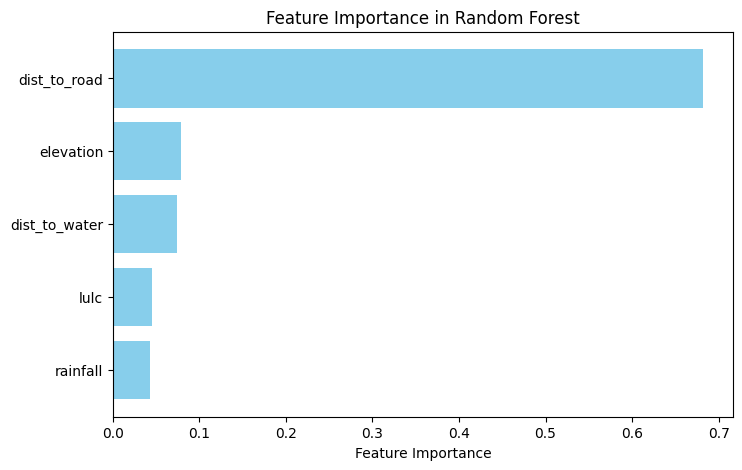

In [ ]:
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'].head(5), feature_importance_df['Importance'].head(5), color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom
plt.show()

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(rf_classifier)

In [ ]:
X_pass=dataset.sample(100)
X_pass.head()

,fid,longitude,latitude,landslide_occ,geology,geomorphology,lithology,soil_class,dist_to_water,dist_to_road,lulc,rainfall,tan_cur,prof_curv,aspect,elevation,slope
5860769,5860770,304005,3354675,0.0,3.0,2.0,3.0,1.0,930.38904,276.58633,4.0,1803.3972,-0.00399,-0.00317,65.23827,1052,51.19432
3130228,3130229,285375,3380295,0.0,4.0,2.0,27.0,1.0,241.84312,0.00000,5.0,1693.2289,0.00007,0.01171,254.68314,1753,34.14742
5590,5591,222375,3392415,0.0,5.0,2.0,30.0,1.0,1485.37903,247.38634,4.0,1673.7853,0.00112,0.00273,160.88702,2063,24.00749
1042581,1042582,262785,3366885,0.0,3.0,2.0,9.0,1.0,0.00000,123.69317,5.0,1271.4931,-0.00396,-0.00630,90.00000,1440,26.94575
679904,679905,239715,3375945,0.0,5.0,15.0,43.0,1.0,2609.04468,360.00000,2.0,1340.6242,-0.01179,0.00699,252.66676,2190,34.42233


In [ ]:
X_pos = dataset[dataset['landslide_occ']==1]
X_pos.head()

,fid,longitude,latitude,landslide_occ,geology,geomorphology,lithology,soil_class,dist_to_water,dist_to_road,lulc,rainfall,tan_cur,prof_curv,aspect,elevation,slope
12533,12534,225345,3391695,1.0,5.0,2.0,30.0,1.0,361.21109,0.00000,4.0,1676.3947,-0.00883,0.00450,157.20348,1841,17.32063
15689,15690,226545,3391395,1.0,5.0,9.0,30.0,1.0,299.96948,0.00000,4.0,1674.8932,-0.00712,-0.00995,243.12186,1939,18.82966
19792,19793,220965,3391005,1.0,5.0,2.0,30.0,1.0,1168.34167,30.00000,4.0,1691.3962,0.00218,-0.00433,218.81139,1640,44.53498
25552,25553,213795,3390555,1.0,5.0,9.0,30.0,1.0,42.42209,0.00000,4.0,1713.9921,-0.00204,-0.00075,272.46576,937,41.07672
45883,45884,213435,3389565,1.0,5.0,15.0,33.0,1.0,127.26627,339.41125,4.0,1734.0415,-0.00228,-0.00329,119.74488,884,50.41272


In [ ]:
X_pass_new = X_pass.drop(['landslide_occ','fid','longitude','latitude'], axis=1)

In [ ]:
X_pos_new = X_pos.drop(['landslide_occ','fid','longitude','latitude'], axis=1)

In [ ]:
X_pos_new.head()

,geology,geomorphology,lithology,soil_class,dist_to_water,dist_to_road,lulc,rainfall,tan_cur,prof_curv,aspect,elevation,slope
12533,5.0,2.0,30.0,1.0,361.21109,0.00000,4.0,1676.3947,-0.00883,0.00450,157.20348,1841,17.32063
15689,5.0,9.0,30.0,1.0,299.96948,0.00000,4.0,1674.8932,-0.00712,-0.00995,243.12186,1939,18.82966
19792,5.0,2.0,30.0,1.0,1168.34167,30.00000,4.0,1691.3962,0.00218,-0.00433,218.81139,1640,44.53498
25552,5.0,9.0,30.0,1.0,42.42209,0.00000,4.0,1713.9921,-0.00204,-0.00075,272.46576,937,41.07672
45883,5.0,15.0,33.0,1.0,127.26627,339.41125,4.0,1734.0415,-0.00228,-0.00329,119.74488,884,50.41272


In [ ]:
shap_values_ = explainer(X_pos_new)

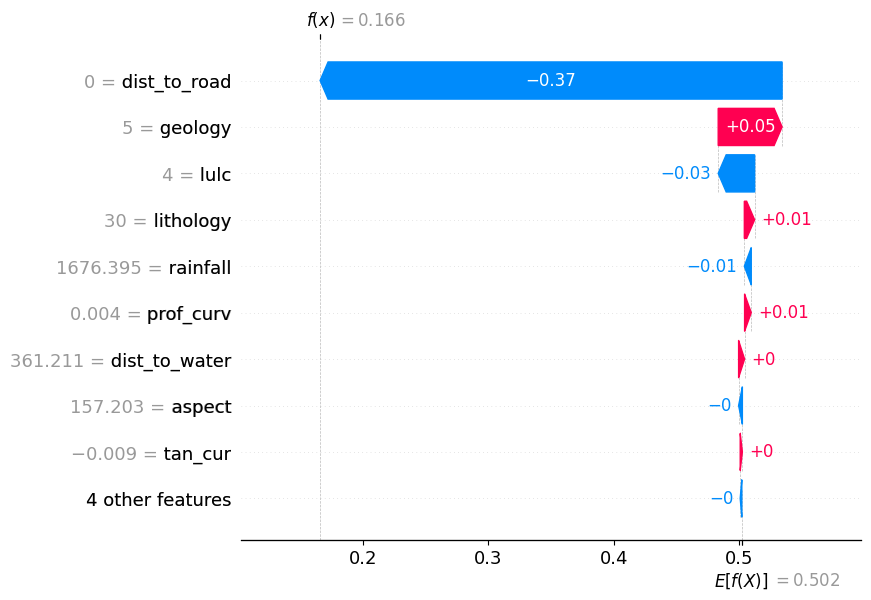

In [ ]:
shap.plots.waterfall(shap_values_[0,:,0])

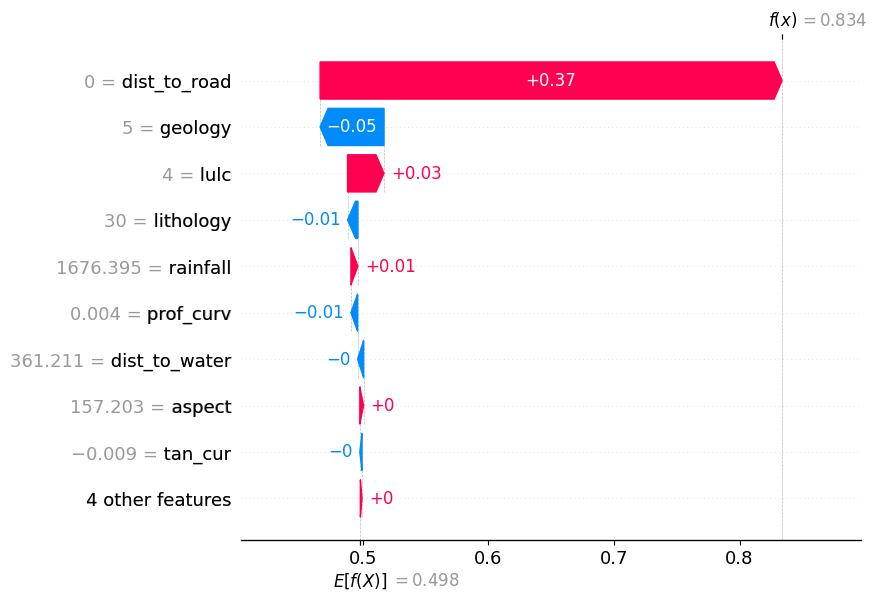

In [ ]:
 shap.plots.waterfall(shap_values_[0,:,1])

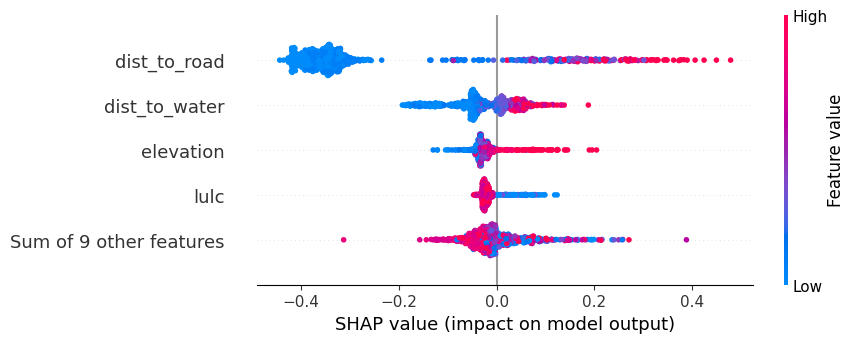

In [ ]:
shap.plots.beeswarm(shap_values_[:,:,0], max_display=5)

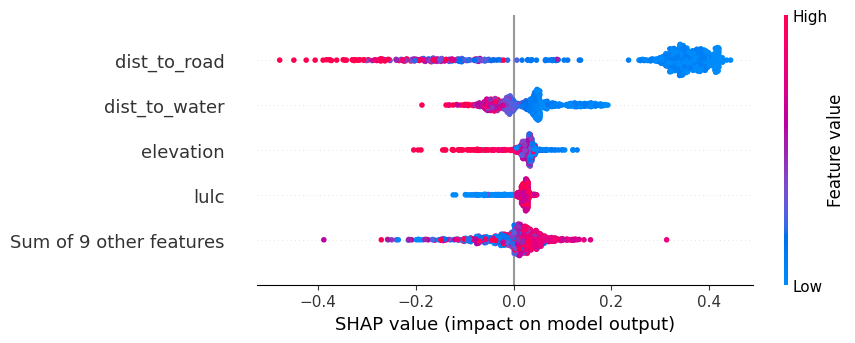

In [ ]:
shap.plots.beeswarm(shap_values_[:,:,1], max_display=5)

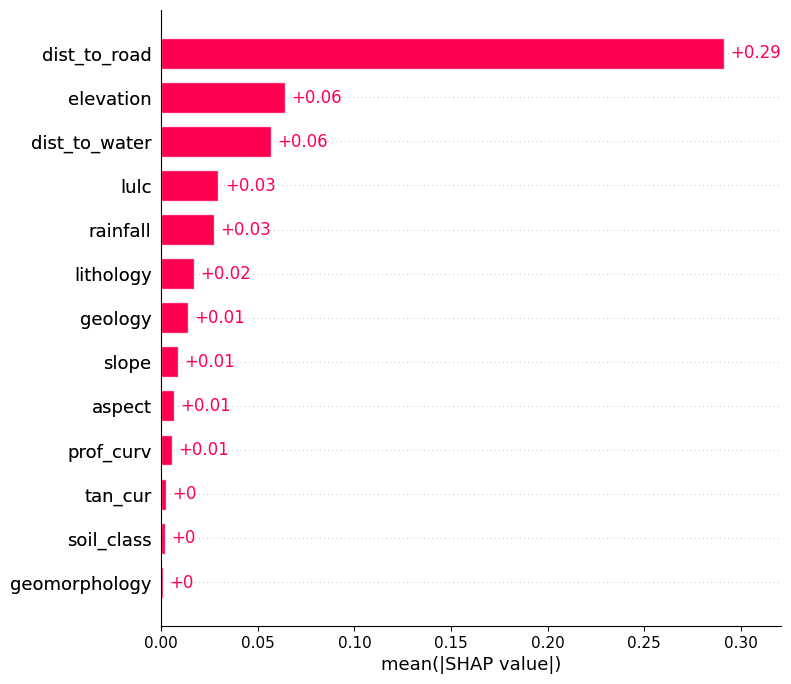

In [ ]:
shap.plots.bar(shap_values_[:,:,0],max_display=13)

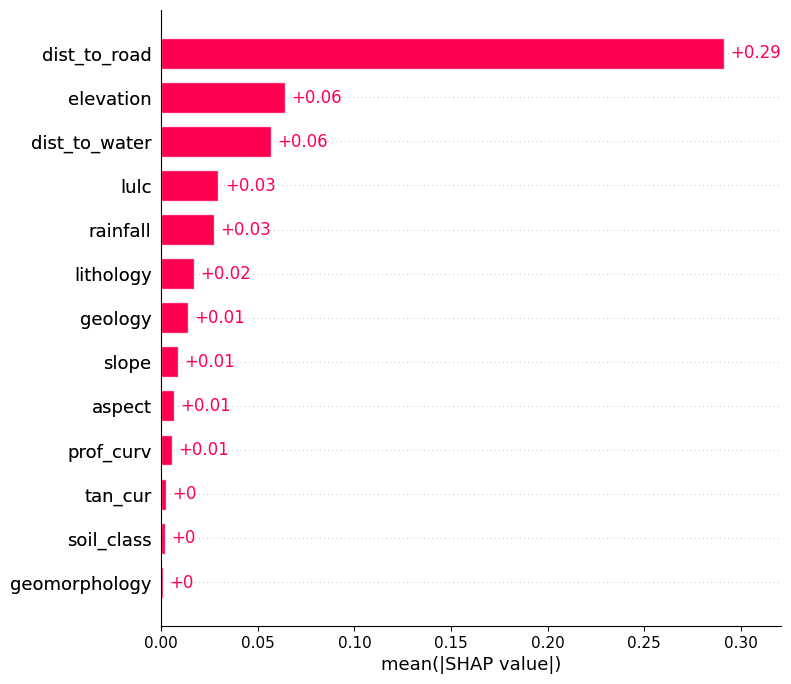

In [ ]:
shap.plots.bar(shap_values_[:,:,1],max_display=13)

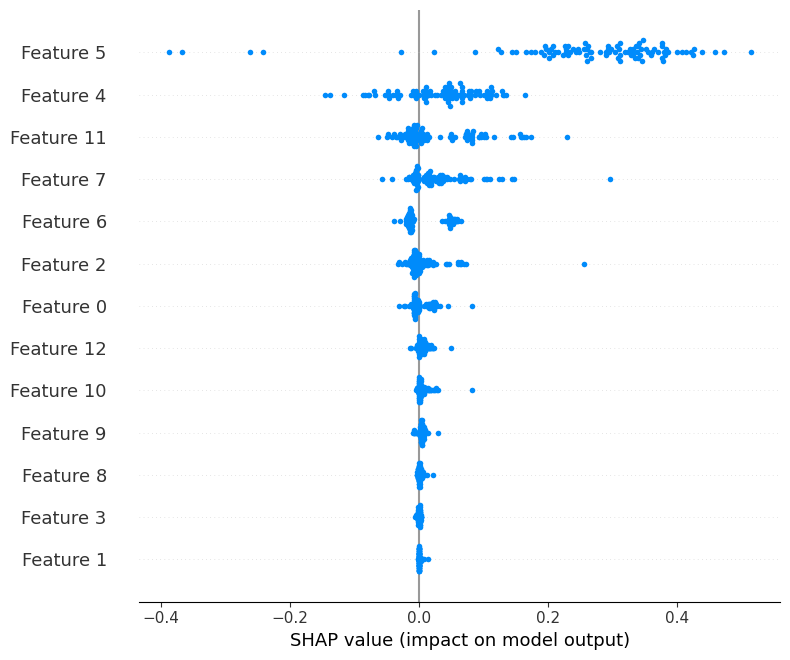

In [ ]:
shap.summary_plot(shap_values_[:, :, 0], show=False)
plt.tight_layout()
plt.show()

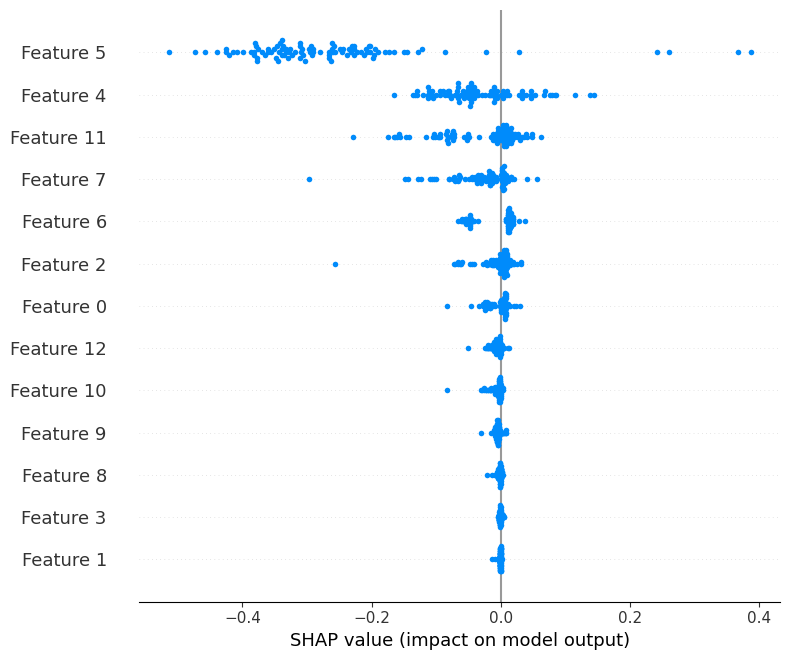

In [ ]:
shap.summary_plot(shap_values_[:, :, 1], show=False)
plt.tight_layout()
plt.show()

In [ ]:
shap_values_

(100, 13, 2)

### **ExtremeGradientBoosting**

In [ ]:
negative_instances = 6227428
positive_instances = 882

scale_pos_weights = negative_instances / positive_instances

xgb_classifier = XGBClassifier(max_depth=3,scale_pos_weight=scale_pos_weights, n_estimators=30)

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9015880712424398


In [ ]:
feature_importances = xgb_classifier.feature_importances_

feature_names = list(X.columns)
feature_importance_map = dict(zip(feature_names, feature_importances))

sorted_feature_importance_map = dict(sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True))

# Print or visualize sorted feature importances
for feature, importance in sorted_feature_importance_map.items():
    print(f"{feature}: {importance}")

dist_to_road: 0.43414825201034546
dist_to_water: 0.10837706923484802
geology: 0.0842977836728096
rainfall: 0.0661860927939415
lithology: 0.044576793909072876
elevation: 0.042017873376607895
slope: 0.039773788303136826
prof_curv: 0.03332625702023506
soil_class: 0.03173211216926575
aspect: 0.03127889707684517
geomorphology: 0.031244469806551933
lulc: 0.02743474952876568
tan_cur: 0.02560579776763916


In [ ]:
dist_to_road = 0.43414825201034546
dist_to_water = 0.10837706923484802
geology = 0.0842977836728096
rainfall = 0.0661860927939415
lithology = 0.04457679390907286

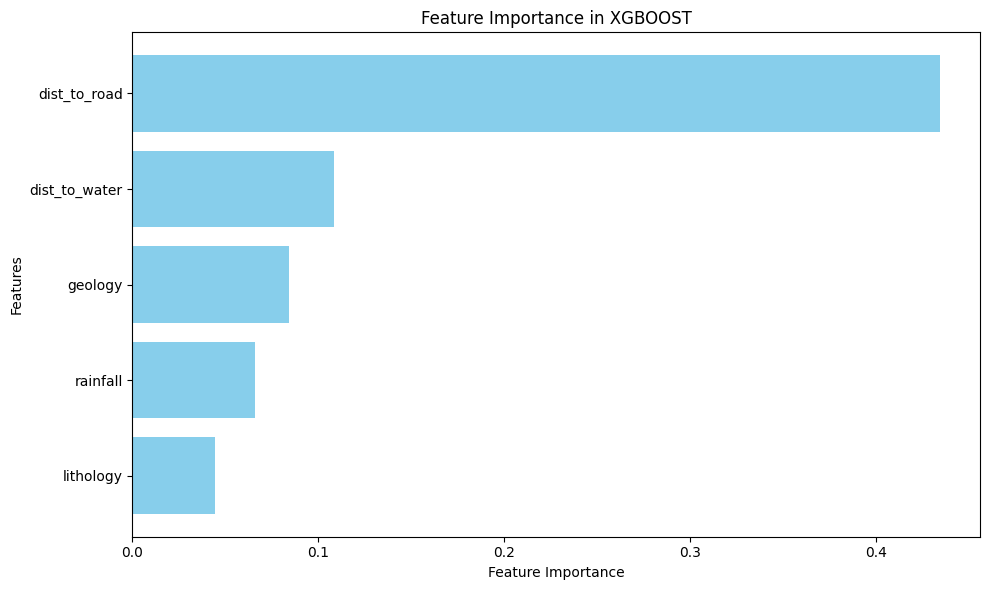

In [ ]:
import matplotlib.pyplot as plt

# Data
features = ['dist_to_road', 'dist_to_water', 'geology', 'rainfall', 'lithology']
importances = [0.43414825201034546, 0.10837706923484802, 0.0842977836728096, 0.0661860927939415, 0.04457679390907286]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')

# Adding labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in XGBOOST')
#plt.xticks(rotation=45)
plt.gca().invert_yaxis()
# Show plot
plt.tight_layout()
plt.show()


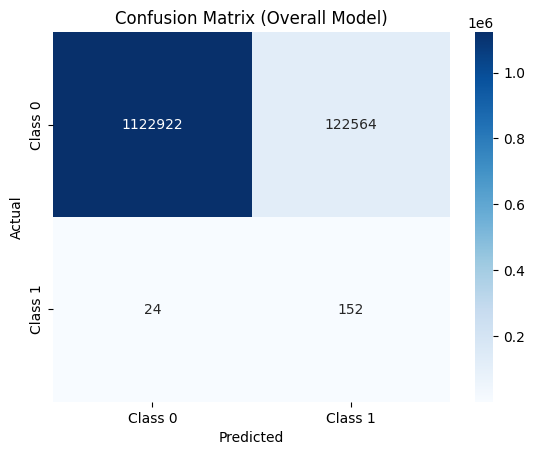

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Overall Model)')
plt.show()

In [ ]:
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.94


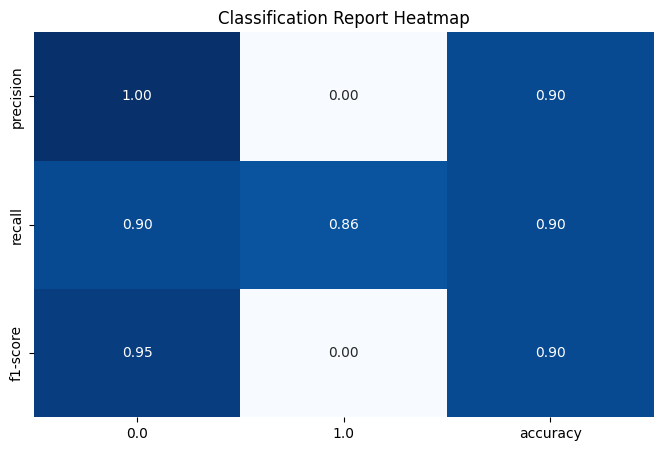

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report)
plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap')
plt.show()

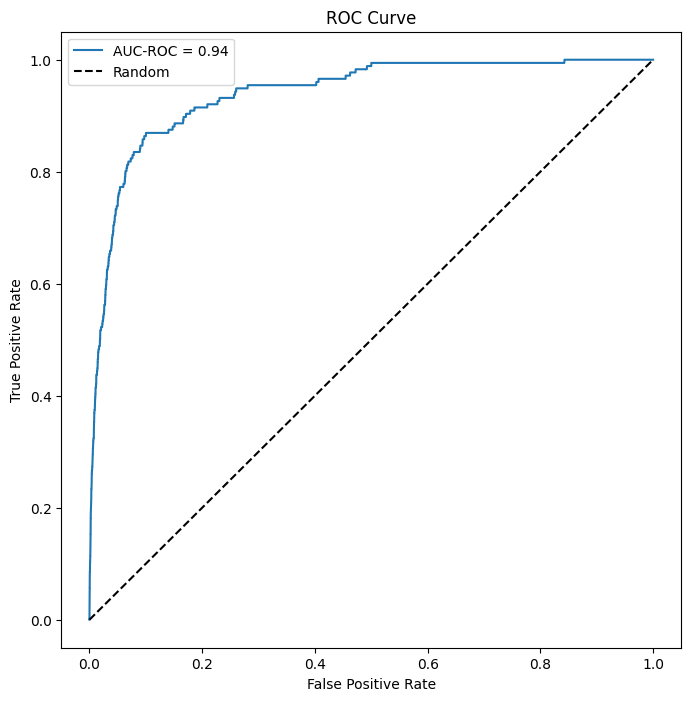

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### **CNN 1D**

In [ ]:
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

In [ ]:
print(X_train_array.shape, X_test_array.shape)

(4982648, 13) (1245662, 13)


In [ ]:
X_train_array

array([[5.0000000e+00, 2.0000000e+00, 4.3000000e+01, ..., 3.1655000e-01,
        1.4710000e+03, 3.7022800e+01],
       [5.0000000e+00, 2.0000000e+00, 3.0000000e+01, ..., 1.8712502e+02,
        7.7900000e+02, 3.1160070e+01],
       [5.0000000e+00, 9.0000000e+00, 3.2000000e+01, ..., 2.2287891e+02,
        5.3200000e+02, 9.0460300e+00],
       ...,
       [5.0000000e+00, 1.5000000e+01, 3.0000000e+01, ..., 2.7309406e+02,
        1.3880000e+03, 1.7159820e+01],
       [2.0000000e+00, 1.4000000e+01, 1.2000000e+01, ..., 2.4120980e+01,
        6.1220000e+03, 3.1456140e+01],
       [4.0000000e+00, 2.0000000e+00, 1.6000000e+01, ..., 4.3987000e+00,
        1.7570000e+03, 3.5231530e+01]])

In [ ]:
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0],X_train_array.shape[1],1))
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0],X_test_array.shape[1],1))

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(4982648, 13, 1)
(1245662, 13, 1)


In [ ]:
from sklearn.utils import class_weight
cls_wgts = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cls_wgts = {i : cls_wgts[i] for i, label in enumerate(sorted(np.unique(y_train)))}
cls_wgts

{0: 0.5000708559031799, 1: 3528.787535410765}

In [ ]:
print()

In [ ]:
model = Sequential([
    Conv1D(filters=16, kernel_size=3, input_shape=(13,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=16, kernel_size=3),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 16)            64        
                                                                 
 batch_normalization (Batch  (None, 11, 16)            64        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 16)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 16)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 16)             784       
                                                                 
 batch_normalization_1 (Bat  (None, 3, 16)             6

In [ ]:
history = History()

In [ ]:
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, validation_split=0.2,class_weight=cls_wgts,verbose=1,callbacks=[history])

Epoch 1/5
 41688/124567 [=========>....................] - ETA: 9:20 - loss: 0.9285 - accuracy: 0.7056

In [ ]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38927/38927 [==============================] - 100s 3ms/step - loss: 0.4848 - accuracy: 0.7699
Test Loss: 0.4847782850265503
Test Accuracy: 0.7698990702629089


In [ ]:
y_pred = model.predict(X_test_reshaped)

38927/38927 [==============================] - 75s 2ms/step


In [ ]:
y_pred_raw_df = pd.DataFrame({'Predicted Probability': y_pred.flatten()})

In [ ]:
rounded_predictions = np.round(y_pred).astype(int)

In [ ]:
y_pred_dataframe = pd.DataFrame({'Predicted Probability': rounded_predictions.flatten()})

In [ ]:
y_pred_dataframe.value_counts()

Predicted Probability
0                        958904
1                        286758
Name: count, dtype: int64

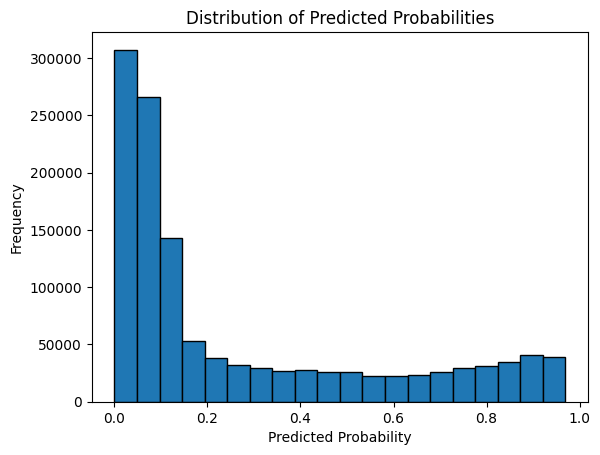

In [ ]:
plt.hist(y_pred_raw_df['Predicted Probability'], bins=20, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

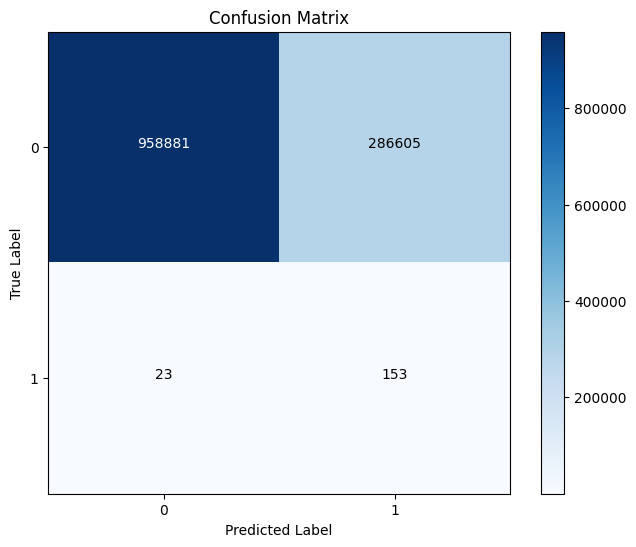

In [ ]:
cm = confusion_matrix(y_test, y_pred_dataframe)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dataframe))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87   1245486
         1.0       0.00      0.87      0.00       176

    accuracy                           0.77   1245662
   macro avg       0.50      0.82      0.44   1245662
weighted avg       1.00      0.77      0.87   1245662



In [ ]:
y_pred_probabilities = y_pred_raw_df['Predicted Probability']
auc_roc = roc_auc_score(y_test, y_pred_probabilities)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8993314863179368


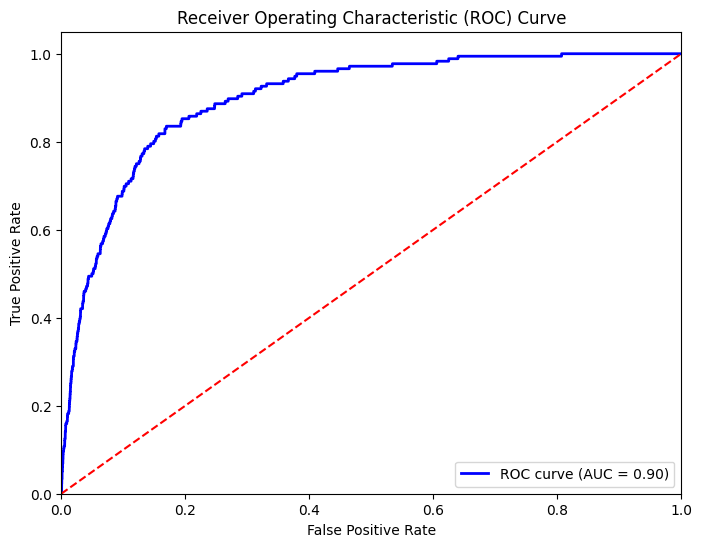

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

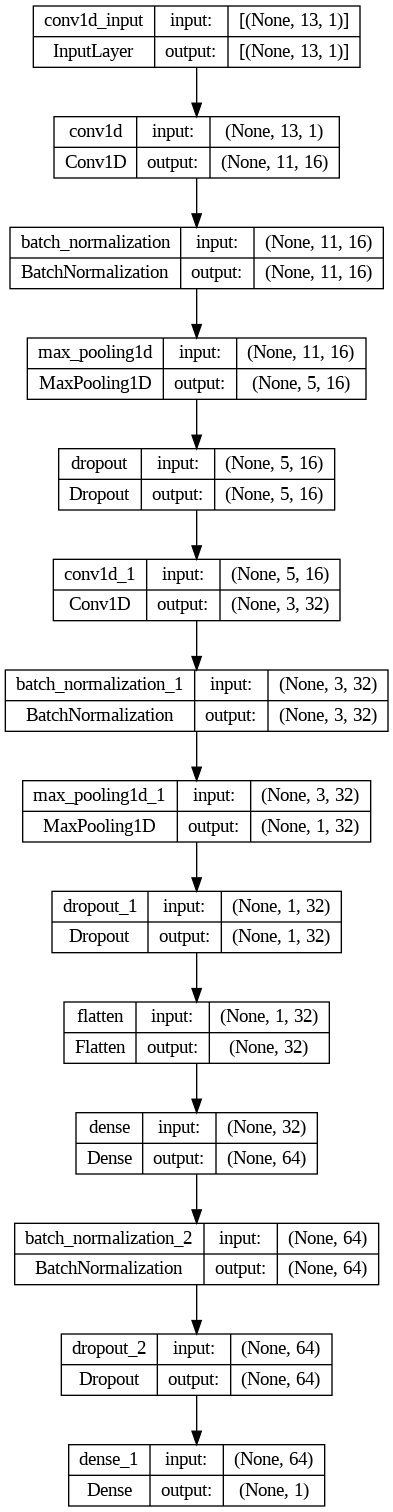

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

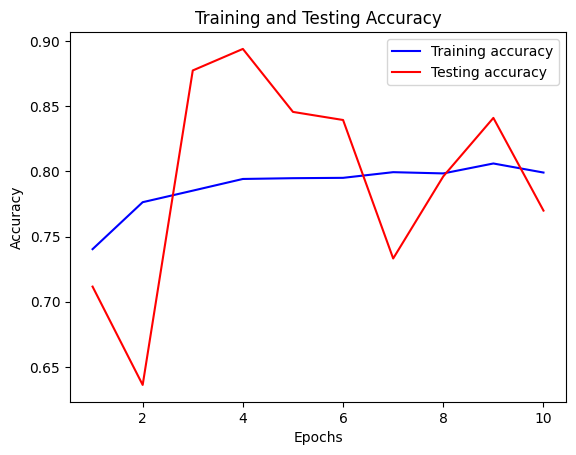

In [ ]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']  # 'val_accuracy' is the key for testing accuracy

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

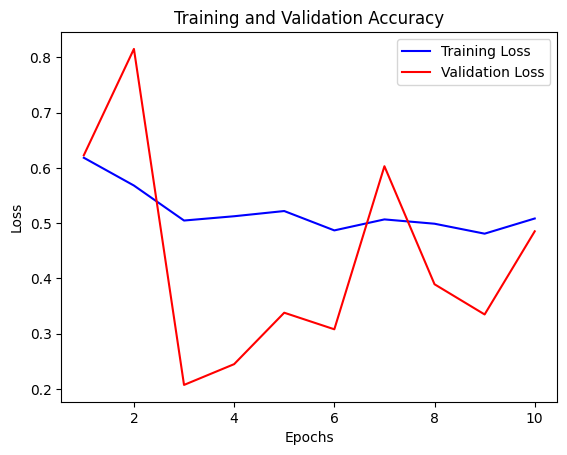

In [ ]:
train_accuracy = history.history['loss']
test_accuracy = history.history['val_loss']  # 'val_accuracy' is the key for testing accuracy

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training Loss')
plt.plot(epochs, test_accuracy, 'r', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
dataset_shuffled_CNN1D = shuffle(dataset, random_state=0)
dataset_proba_CNN1D=dataset_shuffled_CNN1D.drop(['fid','longitude','latitude','landslide_occ'],axis=1,inplace=False)

In [ ]:
dataset_proba_CNN1D_array = dataset_proba_CNN1D.to_numpy()

In [ ]:
dataset_proba_CNN1D_reshaped = dataset_proba_CNN1D_array.reshape((dataset_proba_CNN1D_array.shape[0],dataset_proba_CNN1D_array.shape[1],1))

In [ ]:
probabilities_CNN1D = model.predict(dataset_proba_CNN1D_reshaped)

194635/194635 [==============================] - 402s 2ms/step


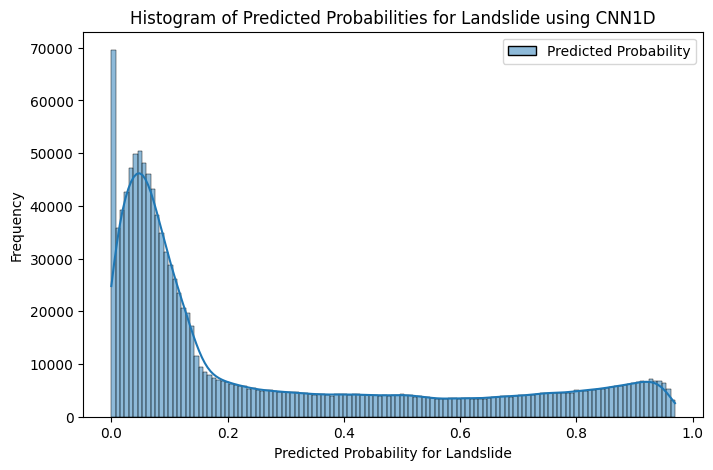

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(probabilities_CNN1D, kde=True, color='skyblue')
plt.title('Histogram of Predicted Probabilities for Landslide using CNN1D')
plt.xlabel('Predicted Probability for Landslide')
plt.ylabel('Frequency')
plt.show()

In [ ]:
result_df = pd.DataFrame({
    'fid': dataset_shuffled_CNN1D['fid'],
    'longitude': dataset_shuffled_CNN1D['longitude'],
    'latitude': dataset_shuffled_CNN1D['latitude'],
    'predicted_probabilities': probabilities_CNN1D
})

#result_df.to_csv('output.csv', index=False)

### **ANN**

In [ ]:
rs = RobustScaler()

In [ ]:
X_scaled = rs.fit_transform(X)

In [ ]:
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] =scaled_df.columns

vif_data["VIF"] = [variance_inflation_factor(scaled_df.values, i)
						for i in range(len(scaled_df.columns))]

print(vif_data)

          feature       VIF
0         geology  3.736205
1   geomorphology  1.412201
2       lithology  3.243997
3      soil_class  2.319784
4   dist_to_water  1.362924
5    dist_to_road  2.007782
6            lulc  1.308720
7        rainfall  1.311993
8         tan_cur  1.194547
9       prof_curv  1.198226
10         aspect  1.010420
11      elevation  3.502943
12          slope  1.054860


In [ ]:
X_train_SCALED, X_test_SCALED, y_train_SCALED, y_test_SCALED = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
ANN_model = Sequential([
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(1, activation='sigmoid')
])

In [ ]:
ANN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cls_wgts = {0:0.5,1:3530}
cls_wgts

{0: 0.5, 1: 3530}

In [ ]:
history_1 = History()

In [ ]:
ANN_model.fit(X_train_SCALED, y_train_SCALED, epochs=10, batch_size=512, validation_split = 0.2, class_weight=cls_wgts, verbose=1,callbacks=[history_1])

Epoch 1/10
7786/7786 [==============================] - 56s 7ms/step - loss: 0.6239 - accuracy: 0.6149 - val_loss: 0.5720 - val_accuracy: 0.6337
Epoch 2/10
7786/7786 [==============================] - 50s 6ms/step - loss: 0.4919 - accuracy: 0.7088 - val_loss: 0.4493 - val_accuracy: 0.7254
Epoch 3/10
7786/7786 [==============================] - 47s 6ms/step - loss: 0.4521 - accuracy: 0.7589 - val_loss: 0.4073 - val_accuracy: 0.7542
Epoch 4/10
7786/7786 [==============================] - 52s 7ms/step - loss: 0.4333 - accuracy: 0.7603 - val_loss: 0.3910 - val_accuracy: 0.7983
Epoch 5/10
7786/7786 [==============================] - 50s 6ms/step - loss: 0.4148 - accuracy: 0.7877 - val_loss: 0.3660 - val_accuracy: 0.8158
Epoch 6/10
7786/7786 [==============================] - 48s 6ms/step - loss: 0.4041 - accuracy: 0.8033 - val_loss: 0.3544 - val_accuracy: 0.8327
Epoch 7/10
7786/7786 [==============================] - 51s 7ms/step - loss: 0.4072 - accuracy: 0.8104 - val_loss: 0.3987 - val_ac

In [ ]:
loss_ANN, accuracy_ANN = ANN_model.evaluate(X_test_SCALED, y_test_SCALED)
print("Test Loss:", loss_ANN)
print("Test Accuracy:", accuracy_ANN)

38927/38927 [==============================] - 72s 2ms/step - loss: 0.3052 - accuracy: 0.8424
Test Loss: 0.30516719818115234
Test Accuracy: 0.8423994779586792


In [ ]:
y_pred_ANN = ANN_model.predict(X_test_SCALED)

38927/38927 [==============================] - 68s 2ms/step


In [ ]:
y_pred_raw_df_ANN = pd.DataFrame({'Predicted Probability': y_pred_ANN.flatten()})

In [ ]:
rounded_predictions_ANN = np.round(y_pred_ANN).astype(int)

In [ ]:
y_pred_dataframe_ANN = pd.DataFrame({'Predicted Probability': rounded_predictions_ANN.flatten()})

In [ ]:
y_pred_dataframe_ANN.value_counts()

Predicted Probability
0                        1049225
1                         196437
Name: count, dtype: int64

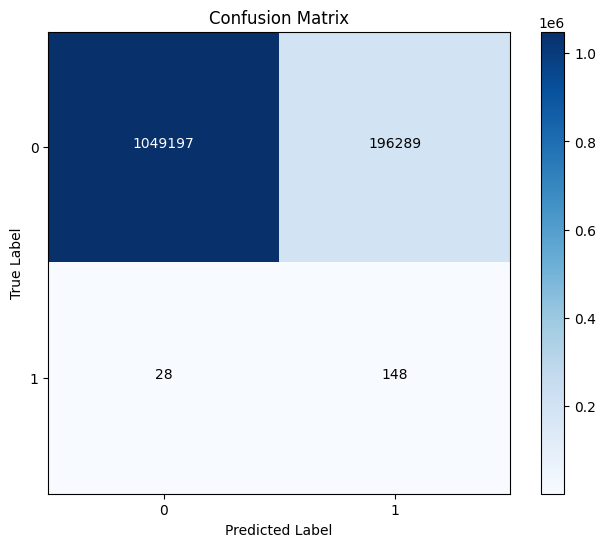

In [ ]:
cm = confusion_matrix(y_test_SCALED, y_pred_dataframe_ANN)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dataframe_ANN))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91   1245486
         1.0       0.00      0.84      0.00       176

    accuracy                           0.84   1245662
   macro avg       0.50      0.84      0.46   1245662
weighted avg       1.00      0.84      0.91   1245662



In [ ]:
auc_roc = roc_auc_score(y_test, y_pred_ANN)
print("AUC-ROC Score:", auc_roc)

NameError: name 'roc_auc_score' is not defined

In [ ]:
type(y_pred_ANN)

numpy.ndarray

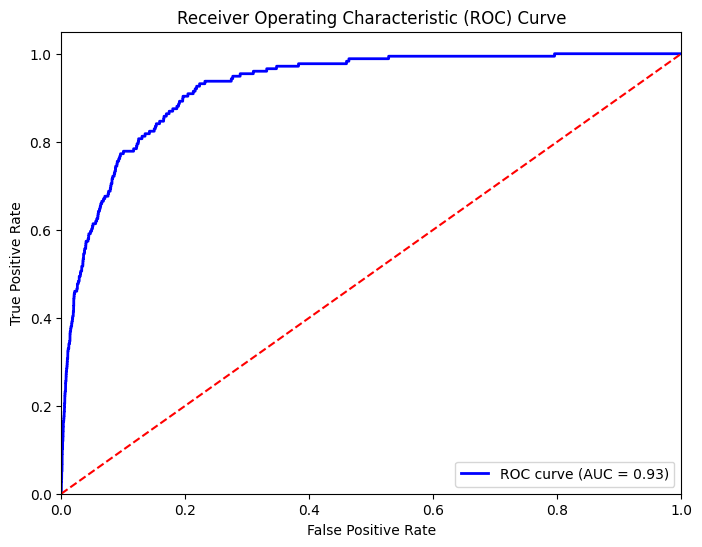

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ANN)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ANN_model.save('ANN_MODEL_SAVED.h5')

In [ ]:
import pickle
with open('ANN_MODEL_Training_History.pkl', 'wb') as file:
    pickle.dump(history_1.history, file)

In [ ]:
np.savetxt('AUC_ROC_SCORE_DF_ANN.csv', y_pred_ANN, delimiter=",")

### **RNN**

In [ ]:
X_train_reshaped_scaled = X_train_SCALED.reshape((X_train_SCALED.shape[0],X_train_SCALED.shape[1],1))
X_test_reshaped_scaled = X_test_SCALED.reshape((X_test_SCALED.shape[0],X_test_SCALED.shape[1],1))

print(X_train_reshaped_scaled.shape)
print(X_test_reshaped_scaled.shape)

(4982648, 13, 1)
(1245662, 13, 1)


In [ ]:
RNN_model = Sequential([
    SimpleRNN(units=16, activation='tanh',return_sequences=True, input_shape=(X_train_reshaped_scaled.shape[1], X_train_reshaped_scaled.shape[2])),
    BatchNormalization(),
    Dropout(0.30),
    Dense(units=8, activation='relu'),
    Dropout(0.30),
    GlobalAveragePooling1D(),
    Dense(units=1, activation='sigmoid')
])

In [ ]:
RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 13, 16)            288       
                                                                 
 batch_normalization_13 (Ba  (None, 13, 16)            64        
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 13, 16)            0         
                                                                 
 dense_13 (Dense)            (None, 13, 8)             136       
                                                                 
 dropout_15 (Dropout)        (None, 13, 8)             0         
                                                                 
 global_average_pooling1d_3  (None, 8)                 0         
  (GlobalAveragePooling1D)                            

In [ ]:
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_3 = History()

In [ ]:
RNN_model.fit(X_train_reshaped_scaled, y_train_SCALED, epochs=5, batch_size=2048, validation_split=0.2, class_weight=cls_wgts, verbose=1,callbacks=[history_3])

Epoch 1/5
1947/1947 [==============================] - 67s 32ms/step - loss: 0.6263 - accuracy: 0.6541 - val_loss: 0.6008 - val_accuracy: 0.6563
Epoch 2/5
1947/1947 [==============================] - 65s 33ms/step - loss: 0.5849 - accuracy: 0.6584 - val_loss: 0.5191 - val_accuracy: 0.7215
Epoch 3/5
1947/1947 [==============================] - 61s 31ms/step - loss: 0.5460 - accuracy: 0.6872 - val_loss: 0.5638 - val_accuracy: 0.6768
Epoch 4/5
1947/1947 [==============================] - 64s 33ms/step - loss: 0.5162 - accuracy: 0.7113 - val_loss: 0.4143 - val_accuracy: 0.7862
Epoch 5/5
1947/1947 [==============================] - 63s 32ms/step - loss: 0.4801 - accuracy: 0.7302 - val_loss: 0.3716 - val_accuracy: 0.8041


In [ ]:
RNN_loss, RNN_accuracy = RNN_model.evaluate(X_test_reshaped_scaled, y_test_SCALED)
print("Test Loss:", RNN_loss)
print("Test Accuracy:", RNN_accuracy)

38927/38927 [==============================] - 101s 3ms/step - loss: 0.3717 - accuracy: 0.8040
Test Loss: 0.37173181772232056
Test Accuracy: 0.8039733171463013


In [ ]:
y_pred_RNN = RNN_model.predict(X_test_reshaped_scaled)

38927/38927 [==============================] - 96s 2ms/step


In [ ]:
y_pred_RNN.shape

(1245662, 1)

In [ ]:
y_pred_raw_RNN_df = pd.DataFrame({'Predicted Probability': y_pred_RNN.flatten()})

In [ ]:
#rounded_predictions_RNN = np.round(y_pred_RNN).astype(int)
rounded_predictions_RNN = (y_pred_RNN >0.5).astype(int)

In [ ]:
y_pred_dataframe_RNN = pd.DataFrame({'Predicted Probability': rounded_predictions_RNN.flatten()})

In [ ]:
y_pred_dataframe_RNN.value_counts()

Predicted Probability
0                        1001399
1                         244263
Name: count, dtype: int64

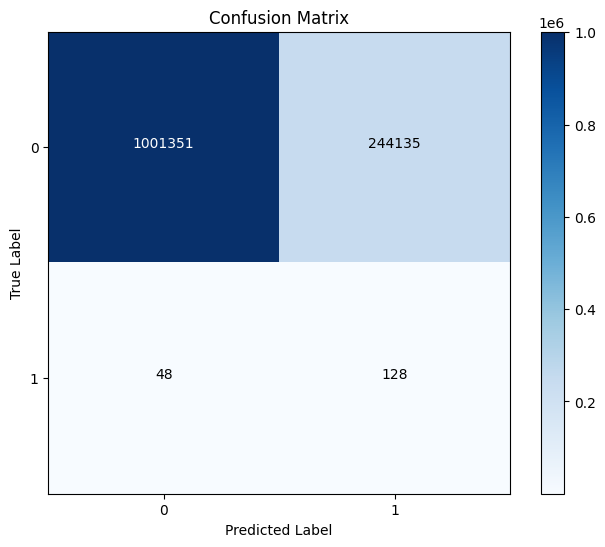

In [ ]:
cm = confusion_matrix(y_test_SCALED, y_pred_dataframe_RNN)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

In [ ]:
RNN_model_new = Sequential([
    SimpleRNN(units=32, activation='relu',return_sequences=True, input_shape=(X_train_reshaped_scaled.shape[1], X_train_reshaped_scaled.shape[2])),
    BatchNormalization(),
    Dropout(0.45),
    Dense(units=16, activation='relu'),
    BatchNormalization(),
    Dropout(0.45),
    SimpleRNN(units=8, activation='relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.45),
    Dense(units=4, activation='relu'),
    BatchNormalization(),
    Dropout(0.45),
    GlobalAveragePooling1D(),
    Dense(units=1, activation='sigmoid')
])

In [ ]:
RNN_model_new.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 13, 32)            1088      
                                                                 
 batch_normalization_22 (Ba  (None, 13, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 13, 32)            0         
                                                                 
 dense_21 (Dense)            (None, 13, 16)            528       
                                                                 
 batch_normalization_23 (Ba  (None, 13, 16)            64        
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 13, 16)           

In [ ]:
RNN_model_new.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_4 = History()

In [ ]:
RNN_model_new.fit(X_train_reshaped_scaled, y_train_SCALED, epochs=5, batch_size=4096, validation_split=0.2, class_weight=cls_wgts, verbose=1,callbacks=[history_4])

Epoch 1/5
974/974 [==============================] - 154s 154ms/step - loss: 0.6670 - accuracy: 0.6123 - val_loss: 0.8195 - val_accuracy: 0.3773
Epoch 2/5
974/974 [==============================] - 144s 148ms/step - loss: 0.6616 - accuracy: 0.5954 - val_loss: 0.3463 - val_accuracy: 0.9996
Epoch 3/5
974/974 [==============================] - 151s 155ms/step - loss: 0.6453 - accuracy: 0.5975 - val_loss: 0.3946 - val_accuracy: 0.9998
Epoch 4/5
974/974 [==============================] - 146s 150ms/step - loss: 0.6639 - accuracy: 0.7066 - val_loss: 0.6739 - val_accuracy: 0.7504
Epoch 5/5
974/974 [==============================] - 145s 149ms/step - loss: 0.6828 - accuracy: 0.6380 - val_loss: 0.6532 - val_accuracy: 0.9998


In [ ]:
RNN_loss_new, RNN_accuracy_new = RNN_model_new.evaluate(X_test_reshaped_scaled, y_test_SCALED)
print("Test Loss:", RNN_loss_new)
print("Test Accuracy:", RNN_accuracy_new)

38927/38927 [==============================] - 189s 5ms/step - loss: 0.3080 - accuracy: 0.9206
Test Loss: 0.3080120384693146
Test Accuracy: 0.9205843806266785


In [ ]:
y_pred_RNN_new = RNN_model_new.predict(X_test_reshaped_scaled)

38927/38927 [==============================] - 133s 3ms/step


In [ ]:
y_pred_raw_RNN_df_new = pd.DataFrame({'Predicted Probability': y_pred_RNN_new.flatten()})

In [ ]:
#rounded_predictions_RNN_new = np.round(y_pred_RNN_new).astype(int)
rounded_predictions_RNN_new = (y_pred_RNN_new>0.48).astype(int)

In [ ]:
y_pred_dataframe_RNN_new = pd.DataFrame({'Predicted Probability': rounded_predictions_RNN_new.flatten()})

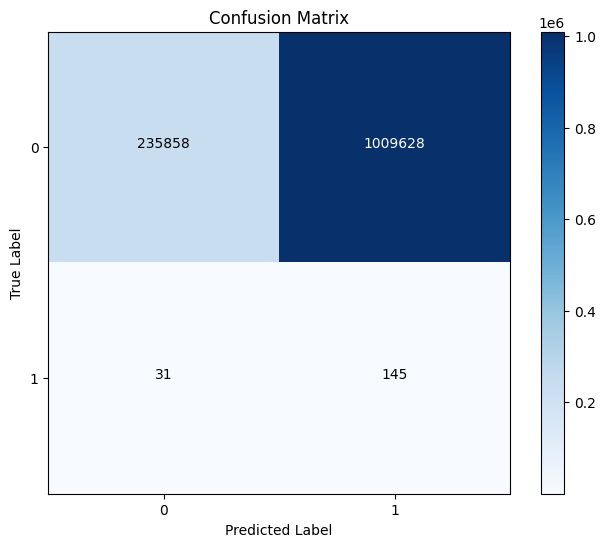

In [ ]:
cm = confusion_matrix(y_test_SCALED, y_pred_dataframe_RNN_new)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

### **CNN 1D**

In [ ]:
X_train_reshaped_scaled = X_train_SCALED.reshape((X_train_SCALED.shape[0],X_train_SCALED.shape[1],1))
X_test_reshaped_scaled = X_test_SCALED.reshape((X_test_SCALED.shape[0],X_test_SCALED.shape[1],1))
print(X_train_reshaped_scaled.shape)
print(X_test_reshaped_scaled.shape)

(4982648, 13, 1)
(1245662, 13, 1)


In [ ]:
CNN_Model = Sequential([
    Conv1D(filters=64,  activation='relu', kernel_size=3, input_shape=(13,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(filters=32,  activation='relu', kernel_size=3),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

CNN_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 64)            256       
                                                                 
 batch_normalization_4 (Bat  (None, 11, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 64)             0         
 D)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 batch_normalization_5 (Bat  (None, 3, 32)            

In [ ]:
history_2 = History()

In [ ]:
CNN_Model.fit(X_train_reshaped_scaled, y_train_SCALED, epochs=5, batch_size=16384, validation_split=0.2, class_weight=cls_wgts,verbose=1,callbacks=[history_2])

Epoch 1/5
244/244 [==============================] - 167s 684ms/step - loss: 0.4004 - accuracy: 0.7795 - val_loss: 0.4020 - val_accuracy: 0.7649
Epoch 2/5
244/244 [==============================] - 165s 677ms/step - loss: 0.3897 - accuracy: 0.7814 - val_loss: 0.3693 - val_accuracy: 0.7889
Epoch 3/5
244/244 [==============================] - 162s 663ms/step - loss: 0.3980 - accuracy: 0.7856 - val_loss: 0.3729 - val_accuracy: 0.7836
Epoch 4/5
244/244 [==============================] - 161s 657ms/step - loss: 0.3934 - accuracy: 0.7899 - val_loss: 0.3836 - val_accuracy: 0.7787
Epoch 5/5
244/244 [==============================] - 164s 673ms/step - loss: 0.4011 - accuracy: 0.7813 - val_loss: 0.3856 - val_accuracy: 0.7822


In [ ]:
CNN_loss, CNN_accuracy = CNN_Model.evaluate(X_test_reshaped_scaled, y_test_SCALED)
print("Test Loss:", CNN_loss)
print("Test Accuracy:", CNN_accuracy)

38927/38927 [==============================] - 86s 2ms/step - loss: 0.3852 - accuracy: 0.7831
Test Loss: 0.38517633080482483
Test Accuracy: 0.7830992937088013


In [ ]:
y_pred_CNN = CNN_Model.predict(X_test_reshaped_scaled)

38927/38927 [==============================] - 84s 2ms/step


In [ ]:
y_pred_raw_CNN_df = pd.DataFrame({'Predicted Probability': y_pred_CNN.flatten()})

In [ ]:
rounded_predictions_CNN_ = np.round(y_pred_CNN).astype(int)

In [ ]:
y_pred_dataframe_CNN_ = pd.DataFrame({'Predicted Probability': rounded_predictions_CNN_.flatten()})

In [ ]:
print(y_pred_dataframe_CNN_.value_counts())

Predicted Probability
0                        975347
1                        270315
Name: count, dtype: int64


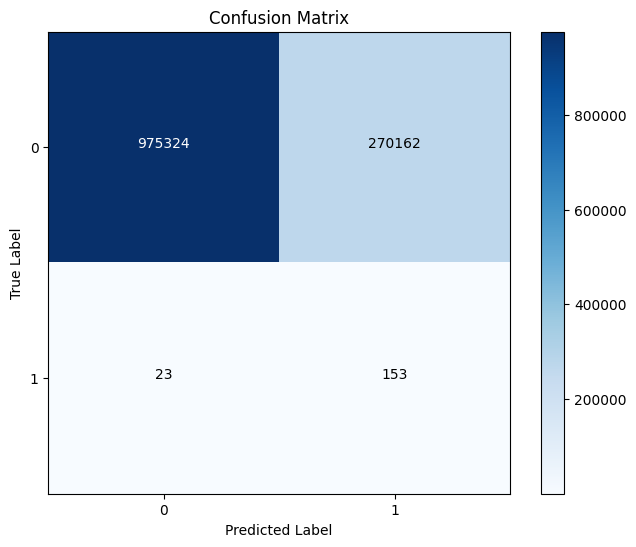

In [ ]:
cm = confusion_matrix(y_test_SCALED, y_pred_dataframe_CNN_)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dataframe_CNN_))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88   1245486
         1.0       0.00      0.87      0.00       176

    accuracy                           0.78   1245662
   macro avg       0.50      0.83      0.44   1245662
weighted avg       1.00      0.78      0.88   1245662



In [ ]:
auc_roc_CNN = roc_auc_score(y_test, y_pred_CNN)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8960197132065133


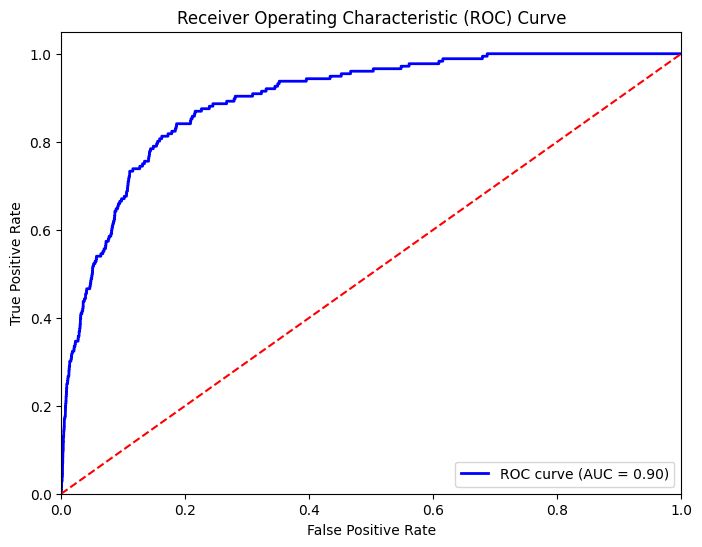

In [ ]:
fpr_CNN, tpr_CNN, thresholds_CNN = roc_curve(y_test, y_pred_CNN)
plt.figure(figsize=(8, 6))
plt.plot(fpr_CNN, tpr_CNN, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc_CNN)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
CNN_Model.save('CNN_MODEL_SAVED.h5')

In [ ]:
import pickle
with open('CNN_MODEL_Training_History.pkl', 'wb') as file:
    pickle.dump(history_2.history, file)

In [ ]:
np.savetxt('AUC_ROC_SCORE_DF_CNN.csv', y_pred_CNN, delimiter=",")

### **Exporting the probabilities for maps**

In [ ]:
dataset_shuffled = shuffle(dataset, random_state=0)

In [ ]:
dataset_proba=dataset_shuffled.drop(['fid','longitude','latitude','landslide_occ'],axis=1,inplace=False)

In [ ]:
dataset_proba_scaled = rs.fit_transform(dataset_proba)

In [ ]:
probabilities_ANN = ANN_model.predict(dataset_proba)

In [ ]:
probabilities_ANN

In [ ]:
pan = pd.DataFrame({'prob':probabilities_ANN.flatten()})

In [ ]:
pan.value_counts()

prob
0.0     6228310
Name: count, dtype: int64

In [ ]:
cprobabilities
class_1_probabilities = probabilities[:, 1]
plt.figure(figsize=(8, 5))
sns.histplot(class_1_probabilities, kde=True, color='skyblue')
plt.title('Histogram of Predicted Probabilities for Class 1')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.show()
len(class_1_probabilities)
result_df = pd.DataFrame({
    'fid': dataset_shuffled['fid'],
    'longitude': dataset_shuffled['longitude'],
    'latitude': dataset_shuffled['latitude'],
    'predicted_probabilities': class_1_probabilities
})
print(result_df)
#result_df.to_csv('output.csv', index=False)